**MO-BOLFI**

The notebook presents an implementation of Multi-objective BOLFI algorithm (arxiv link)
The dataset used is self-collected data for psychology analysis in decision-making (description here).
Feel free to contact e1039688@u.nus.edu if you have any question regarding the paper and the codes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from scipy.optimize import minimize

In [3]:
df = pd.read_csv("D:/onedrive/OneDrive - National University of Singapore/eye-tracking data/choice_resultF3.csv")
df.head(5)


Unnamed: 0                 ID Scenario  alt  chosen    RC  OC   DR    CT  \
0           0  R_3fZBQYRcTj6rtUC   IND1.3    1       1  3000  45  550  11.5   
1           1  R_3fZBQYRcTj6rtUC   IND1.3    3       0  3900  14  350    18   
2           2  R_3fZBQYRcTj6rtUC   IND1.2    1       1  3000  45  550  11.5   
3           3  R_3fZBQYRcTj6rtUC   IND1.2    3       0  3600  14  350    18   
4           4  R_3fZBQYRcTj6rtUC   IND1.1    1       1  3000  45  550  11.5   

   WT  ...  AT4_1  AT4_2  AT4_3  nationality  Gender  marital   age  \
0 NaN  ...    3.0    2.0    2.0          4.0     2.0      1.0  68.0   
1 NaN  ...    3.0    2.0    2.0          4.0     2.0      1.0  68.0   
2 NaN  ...    3.0    2.0    2.0          4.0     2.0      1.0  68.0   
3 NaN  ...    3.0    2.0    2.0          4.0     2.0      1.0  68.0   
4 NaN  ...    3.0    2.0    2.0          4.0     2.0      1.0  68.0   

   experience_months  income  education   
0              300.0     1.5         2.0  
1              300.0     1.5         2.0  
2              300.0     1.5         2.0  
3              300.0     1.5         2.0  
4              300.0     1.5         2.0  

[5 rows x 72 columns]

**Data Preprocessing**

We use all the A and S scenarios. There are 320 observations in the scenarios we use. Each observation represents a candidate answered a question "Which one would you like to choose?" under A1.1 from 3 alternatives (denoted as 1, 3, 4 respectively in raw data), given 3 attributes values for each alternative. The final choice made and fixation trail of each candidate are recorded.


3 attributes:

RC - Renting cost (per month)

OC - Operating cost (per day)

DR - Driving range


The outcome from candidates are fixation_trail and choice. Fixation_trail is the aggregated time of fixation during the scenario. The choice is the final chosen alternative of the candidate.

In [4]:
# define hyper params

number_of_alternatives = 3
number_of_attributes = 2
number_of_discrepancies = 2


In [6]:
# Add data scenarios one by one for convenient adding & deleting new data
df_data = df[df.Scenario == "A1.1"]
df_data = pd.concat([df_data, df[df.Scenario == "A1.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4R"]],axis=0)




# Standardize attributes data
# There are 3 attributes RC OC DR CT
# Response time column: fixation trail
 
df_data.drop(df_data[(df_data.ID=="R_2xESOZsu1b0DK9W")|(df_data.ID=="R_1kUrkeP2G5SzhZ9")|(df_data.ID=="R_3MLEPJF4WwO69ZI")|(df_data.ID=="R_28O4cGfWMqm0fkg")|(df_data.ID=="R_3lMIUHexfItTFyN")|(df_data.ID=="R_3HohVlDFTj1gqWK")].index,inplace= True)


#  remove observations whose RT is outlier

rt_mean = np.mean(df_data.time)

rt_std =  np.std(df_data.time)


df_data.drop(df_data[(df_data.time<np.max([0,(rt_mean-3*rt_std)]))|(df_data.time>(rt_mean+3*rt_std))].index,inplace= True)

df_data.head(5)

Unnamed: 0                 ID Scenario  alt  chosen    RC  OC   DR   CT  \
208         208  R_1MMyGP7w3EwTfMC     A1.1    1       0  3000  41  600   13   
209         209  R_1MMyGP7w3EwTfMC     A1.1    3       1  3000  17  350   22   
210         210  R_1MMyGP7w3EwTfMC     A1.1    4       0  2950  17  250   31   
430         430  R_1I4bJytxmiu84aS     A1.1    1       0  3000  23  850  5.5   
431         431  R_1I4bJytxmiu84aS     A1.1    3       0  3000  14  500    9   

     WT  ...  AT4_1  AT4_2  AT4_3  nationality  Gender  marital   age  \
208 NaN  ...    1.0    2.0    2.0          4.0     2.0      1.0  45.0   
209 NaN  ...    1.0    2.0    2.0          4.0     2.0      1.0  45.0   
210 NaN  ...    1.0    2.0    2.0          4.0     2.0      1.0  45.0   
430 NaN  ...    2.0    2.0    2.0          4.0     2.0      1.0  55.0   
431 NaN  ...    2.0    2.0    2.0          4.0     2.0      1.0  55.0   

     experience_months  income  education   
208               96.0     2.5         3.0  
209               96.0     2.5         3.0  
210               96.0     2.5         3.0  
430              156.0     2.5         3.0  
431              156.0     2.5         3.0  

[5 rows x 72 columns]

In [7]:
# RC & OC & DR
X_matrix = np.array(df_data[["RC","OC","DR","Freq_p_week"]].astype("float64"))

# RC, OC are expected to be small, DR is expected to be large
# Transform the columns RC OC to unify the direction of optimization
# totoal cost
X_matrix[:,0] = -X_matrix[:,0]-X_matrix[:,1]*X_matrix[:,3]*52/12

X_matrix[:,2] = X_matrix[:,2]

X_matrix[:,0] = (X_matrix[:,0]-X_matrix[:,0].min())/(X_matrix[:,0].max()-X_matrix[:,0].min())

X_matrix[:,2] = (X_matrix[:,2]-X_matrix[:,2].min())/(X_matrix[:,2].max()-X_matrix[:,2].min())

X_attributes = pd.DataFrame(np.take(X_matrix, [0,2], axis = 1))


X_attributes = pd.DataFrame(X_attributes.values.reshape(X_attributes.shape[0]//number_of_alternatives, number_of_attributes*number_of_alternatives),
                    columns=['TC1','DR1', 'TC3','DR3', 'TC4', 'DR4']) 

# X_attributes

X_attributes2 = pd.DataFrame(np.take(np.array(X_attributes),[0,1,2,3],axis = 1),
                             columns=['TC1','DR1', 'TC3','DR3'])
print(X_attributes2)

          TC1       DR1       TC3       DR3
0    0.281256  0.615385  0.492271  0.230769
1    0.497295  1.000000  0.553816  0.461538
2    0.680580  0.615385  0.861449  0.230769
3    0.751884  0.923077  0.833527  0.461538
4    0.652367  1.000000  0.727729  0.461538
..        ...       ...       ...       ...
579  0.532077  0.769231  0.758164  0.307692
580  0.576329  0.692308  0.840097  0.307692
581  0.290048  0.769231  0.465894  0.307692
582  0.748406  0.615385  0.848696  0.230769
583  0.590145  0.538462  0.884058  0.230769

[584 rows x 4 columns]


In [8]:
# The response data
# X_response = df_data[["ID","alt","chosen","fixation_trail"]] # for lab dataset
X_response = df_data[["ID","alt","chosen","time"]] # for online dataset
# Change milsecond to second


X_response[["time"]] = X_response[["time"]] # for online dataset

X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
X_response["chosen3"] = 1*(X_response['chosen']==1)*(X_response["alt"]==3)
X_response["chosen4"] = 1*(X_response['chosen']==1)*(X_response["alt"]==4)


X_response = X_response.drop(columns=["alt","chosen"])

condition_chosen = X_response[(X_response['chosen1']==0) & (X_response['chosen3']==0) & (X_response['chosen4']==0)].index
X_response = X_response.drop(condition_chosen)

C:\Users\e0729936\AppData\Local\Temp\ipykernel_20372\1428476389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response[["time"]] = X_response[["time"]] # for online dataset
C:\Users\e0729936\AppData\Local\Temp\ipykernel_20372\1428476389.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
C:\Users\e0729936\AppData\Local\Temp\ipykernel_20372\1428476389.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [9]:
X_attributes.shape

(584, 6)

In [10]:
X_response.describe()

time     chosen1     chosen3     chosen4
count  584.000000  584.000000  584.000000  584.000000
mean    11.468971    0.410959    0.450342    0.138699
std     11.384608    0.492430    0.497955    0.345928
min      1.021000    0.000000    0.000000    0.000000
25%      4.238250    0.000000    0.000000    0.000000
50%      7.764500    0.000000    0.000000    0.000000
75%     14.319750    1.000000    1.000000    0.000000
max     68.911000    1.000000    1.000000    1.000000

**MLBA Simulator**

This section defines a simulator model that generates outcomes (fixation_trail, choice) given a set of parameter values and attributes data. The model refers to *[Hancock et al, 2021](https://www.sciencedirect.com/science/article/abs/pii/S0191261521000576)*.


For Citation: Hancock, Thomas O., et al. "An accumulation of preference: two alternative dynamic models for understanding transport choices." Transportation Research Part B: Methodological 149 (2021): 250-282.

In [11]:
def create_distance_matrix(row, number_of_alternatives,number_of_attributes):
    rows = row.values.reshape(number_of_alternatives,-1)
    distance_matrix = np.zeros((number_of_alternatives,number_of_alternatives,number_of_attributes))
    for i in range(number_of_alternatives):
      for j in range(number_of_alternatives):
        distance_matrix[i,j,:] = rows[i,:]-rows[j,:]

    return distance_matrix

# Test using first row (obs) of the data
create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

array([[[ 0.        ,  0.        ],
        [-0.21101449,  0.38461538],
        [-0.22550725,  0.53846154]],

       [[ 0.21101449, -0.38461538],
        [ 0.        ,  0.        ],
        [-0.01449275,  0.15384615]],

       [[ 0.22550725, -0.53846154],
        [ 0.01449275, -0.15384615],
        [ 0.        ,  0.        ]]])

In [12]:
distance_matrix = create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

distance_matrix[2,0:2,0]

array([0.22550725, 0.01449275])

In [13]:
test_matrix = np.zeros((2,len(X_attributes)))
for i in range(len(X_attributes)):
    test_matrix[:,i] =  create_distance_matrix(X_attributes.iloc[i,:],number_of_alternatives,number_of_attributes)[1,0:2,1]
    
    
pd.DataFrame(test_matrix.transpose()).describe()

0      1
count  584.000000  584.0
mean    -0.428214    0.0
std      0.061396    0.0
min     -0.538462    0.0
25%     -0.461538    0.0
50%     -0.461538    0.0
75%     -0.384615    0.0
max     -0.307692    0.0

In [15]:
def compute_mean_drift_rate(X_attributes,lambdas,log_I0,betas,deltas):
    number_of_alternatives = len(deltas)+1
    number_of_candidates = int(X_attributes.shape[0])
    means = np.zeros((X_attributes.shape[0], number_of_alternatives))
    lambda0, lambda1 = lambdas[0], lambdas[1]
  
    for n in range(number_of_candidates):
        attributes_n = X_attributes.iloc[n,:] # attributes of individual n
        distance_matrix = create_distance_matrix(attributes_n, number_of_alternatives, number_of_attributes)
        Lambda = np.where(distance_matrix>0,lambda0,lambda1)
        Beta = np.repeat(np.repeat(np.array(betas).reshape(1,-1),number_of_alternatives,axis=0),number_of_alternatives,axis=0).reshape(-1,number_of_alternatives,number_of_attributes)
        weight_temp = -1*np.multiply(Lambda,np.multiply(Beta,np.absolute(distance_matrix)))
        
        weight_temp = np.where(weight_temp<50, weight_temp, 50)
        weight_temp = np.where(weight_temp>-50, weight_temp, -50)
        
  
        weights_matrix = np.exp(weight_temp)
        V_n = np.multiply(weights_matrix,np.multiply(Beta,distance_matrix))
        V_n = np.sum(np.sum(V_n,axis=2),axis=1)
        delta1 = np.zeros((1,1))
        Delta = np.concatenate((np.array(deltas).reshape(1,-1),delta1),axis=1) # set the last alternative as reference
        V_n = V_n + Delta + np.exp(log_I0)
        # the mean drift rate is non-negative
        means[n,:] = np.where(V_n>0, V_n, 0) # the mean drift rate is non-negative

    return means

In [16]:
#Test
means = compute_mean_drift_rate(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(1),
                        betas=[2,0.12],deltas=[-0.2,22])
means

array([[ 0.11015874, 23.3484685 ,  1.37784737],
       [ 0.69802113, 23.03759659,  1.06882616],
       [ 0.21229414, 23.29276721,  1.32247485],
       ...,
       [ 0.26275216, 23.29162278,  1.27074802],
       [ 0.51408929, 23.15772694,  1.1371211 ],
       [ 0.        , 23.52447683,  1.50295826]])

In [17]:
means.shape

# (1208,3)

(584, 3)

In [18]:
import scipy.stats

def MLBA(X_attributes, lambdas,log_I0,  betas, deltas, threshold, A = 48, s=1 ):
    """
    MLBA simulator
    input: parameters that are derectly used in MLBA model & data X
    output: choice outcome and response time
    Details:
    A:starting point upper bound such that start points of accumulators will follow this Unif(0,A).
    threshold: threshold is the boundary which reaches the first accumulator(final choice), here actually is log(threshold-A) 
    X_response: Choice made and coresponding response time of candidates
    s: common sd of N(u_n, s), the drift rate of the ith accumulator d_n~N(u_n, s)
    u_n: mean values u_n, computed from compute_mean_drift_rate() for individual n

    """

    number_of_candidates = int(X_attributes.shape[0])
    
########################## 
    threshold = np.exp(threshold)+A
    betas = np.exp(betas)
    # lambdas = np.exp(lambdas)

   
    number_of_alternatives = len(deltas)+1
    # Initialize the accumulators and the starting point
    accumulators = np.zeros((number_of_candidates,number_of_alternatives))
    start_points = np.random.uniform(low=0, high=A, size=(number_of_candidates,number_of_alternatives))
    accumulators = accumulators + start_points

    # Compute the mean of normals that drift rate follows for each accumulator
    means = compute_mean_drift_rate(X_attributes, lambdas, log_I0, betas, deltas)
    drift_rates = means
    # print(means)
    for i in range(number_of_candidates):
        for j in range(number_of_alternatives):
            drift_rates[i,j] = scipy.stats.truncnorm.rvs(a = (0- means[i,j])/s, b = (400- means[i,j])/s , loc= means[i,j], scale=s).item() 
            # here to only draw non-negative drift rate so that no need for the non-negative drift rate check in the following
    # print(drift_rates)
    # drift_rates = means + np.random.standard_normal(size=(number_of_candidates,number_of_alternatives)) * s

    # here to only include non-native sampler

    # For each candidate, run the mlba simulation game
    rt = np.zeros(number_of_candidates)
    choice = np.zeros((number_of_candidates,number_of_alternatives))
    for n in range(number_of_candidates):
        accumulators_n = accumulators[n,:]
        drift_rates_n = drift_rates[n,:]
        rt_candidate = (threshold-start_points[n,:])/drift_rates_n
        choice_n = np.argmin(rt_candidate)
        choice[n,choice_n] = 1
        rt[n] = rt_candidate[choice_n]

    return (rt,choice)

In [19]:
#Test
MLBA(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(10),
                        betas=[1,0.5],deltas=[-10,-0.3], threshold=5)

(array([14.30516152, 19.47718524, 17.35271594, 16.86975661, 19.85859814,
        17.30512204, 18.35342224, 15.49797774, 16.29835897, 15.10356056,
        15.80462583, 15.83040294, 20.32485147, 15.56590791, 19.20044545,
        15.77350315, 16.0227032 , 17.1923557 , 19.02025562, 16.67169615,
        18.77616208, 17.81053902, 14.24369795, 15.51484095, 14.54971866,
        18.20936995, 16.51219712, 16.44378836, 16.73163766, 15.78131243,
        16.30775307, 18.38822116, 15.79281352, 15.73497831, 17.79348792,
        17.92490141, 17.88729904, 15.60800761, 22.50608366, 14.42467645,
        15.36939433, 16.14027719, 17.46107538, 14.4379522 , 15.68670983,
        15.81809608, 15.12832539, 13.70894319, 16.7910791 , 16.4709201 ,
        19.39546184, 16.56526791, 17.47399009, 18.21214277, 15.1278321 ,
        15.76306599, 18.29908418, 15.11786409, 13.43112908, 16.80363519,
        14.11545065, 16.4191551 , 19.50568908, 14.2094652 , 13.00842196,
        16.14039572, 16.99768973, 15.56592412, 17.1

***Optional: Define discrepancies between some summary statistics on simulated and observed data. Currently the raw rt & choice data is viewed as summary statistics on itself. Given the possible multimodal posterior of parameters of MLBA, using raw data (with no infor loss) might be the safe strategy in this case.***

In [20]:
def per_sample(raw,theta,X_response_rt,nObs):
    lambdas, log_I0, betas, deltas, threshold = theta
    (rt_sim,choice_sim) = MLBA(X_attributes, lambdas, log_I0, betas, deltas, threshold)

    tmp_rt =np.mean(np.abs(np.log(np.sort(X_response_rt))-np.log(np.sort(rt_sim))))/3
    tmp_ch = choice_sim.mean(axis=0)
    
 
    return([ tmp_rt,tmp_ch])

In [22]:
from joblib import Parallel, delayed


def minus_simluated_discrepancy(theta, X_response=X_response, X_attributes=X_attributes):
    """
    X_response: Observed choice and coresponding response time of candidates
    X_attributes: standardized data of attributes of alternatives, used for compute mean value of normals that drift rates follow
    Each row of X is an individual-specific alternvative's attributes
    theta: a vector of all parameters, orderly including (lambdas, log_I0, betas, deltas, log_(threshold-A))
    output: distance between simulated choice & resposne time and observed choice & response time
    We take log of I0 and threshold because they are positive numbers, taking log maps them to the whole real line, which is approporaite for prior definition and MCMC
    """
    
   
   # Observed data
    X_response_rt = X_response[["time"]].values
    X_response_choice = X_response[["chosen1","chosen3","chosen4"]].values

    # lambdas, log_I0, betas, deltas, threshold = theta
    X_response_rt = X_response_rt.reshape(-1)
    
    nObs = len(X_response)

    # Simulation discrepancy (take log of rt discrepancy)
    # iter_n replicate number
    iter_n = 50
    discrepancies = np.zeros((1,number_of_discrepancies)) # 2 discrepancies
    X_response_ch = np.array(X_response_choice.mean(axis = 0))

    
    res =pd.DataFrame(Parallel(n_jobs = 20)(delayed(per_sample)(row,theta,X_response_rt,nObs) for row in range(iter_n)),columns=["RT","CH"])

    
    dis_1_tes = np.mean(res.RT)
    discrepancy_rt = np.where(dis_1_tes >1e-5,np.log(dis_1_tes),np.log(1e-5))
 
    choice_candidate = np.array(res.CH.to_list()).reshape((iter_n,number_of_alternatives))
    dis_2_tes = np.mean(( choice_candidate-X_response_ch)**2,axis=0).sum()
    discrepancy_choice = np.where(dis_2_tes >1e-5,np.log(dis_2_tes),np.log(1e-5))
    discrepancies[0,:] = (discrepancy_rt, discrepancy_choice)
    


    return discrepancies*-1


In [23]:
minus_simluated_discrepancy(theta=([0.1,0.2], np.log(0.5), [0.2,0.12], [-10,0.1],np.log(70)))

array([[0.30806492, 3.18709533]])

MO-BOLFI is a likelihood-free inference method that effectively surrogates simulators like MLBA model. **We'll show that it can surrogate MLBA and generate data highly similar with the MLBA-simulated data.**

Thus, instead of using X_response, we'll generate "real response" by simulated dataset given a self-defined "real parameter".

The real parameter is chosen to be a proper value that simulates stable, well distributed "real resposne". Random choice of real parameter may make real resposne a bad data in model fitting (e.g. a dataset with all candidates choosing the same alternative)

In the rest of this notebook, the "real_response" we generated in the following chunk will be viewed as the real data.



In [24]:
#  CF MAP value
real_theta  = [9.404336e-02 ,0,0,-8.758533e-01,0,2.080699e+00,1.414022e+00,  6.108216e-01] # DR
real_theta 

[0.09404336, 0, 0, -0.8758533, 0, 2.080699, 1.414022, 0.6108216]

In [25]:
real_data = MLBA(X_attributes,lambdas=real_theta[0:2], log_I0=real_theta[2],
                    betas=real_theta[3+number_of_alternatives-1:3+number_of_attributes+number_of_alternatives-1],
                    deltas=real_theta[3:3+number_of_alternatives-1],
                    threshold= real_theta[-1])

real_response = pd.DataFrame(real_data[1], columns=["chosen1", "chosen3", "chosen4"])
real_response = pd.concat([pd.DataFrame(real_data[0], columns = ["time"]), real_response],axis=1)

In [26]:
real_response.describe() # closed-form


time     chosen1     chosen3     chosen4
count  584.000000  584.000000  584.000000  584.000000
mean    11.521773    0.469178    0.325342    0.205479
std     10.640439    0.499477    0.468904    0.404398
min      0.676661    0.000000    0.000000    0.000000
25%      4.449320    0.000000    0.000000    0.000000
50%      8.936600    0.000000    0.000000    0.000000
75%     14.782019    1.000000    1.000000    0.000000
max     93.857386    1.000000    1.000000    1.000000

In [28]:
real_response = X_response

In [29]:
print(X_response.time[X_response.chosen1==1].describe())
print(X_response.time[X_response.chosen3==1].describe())
print(X_response.time[X_response.chosen4==1].describe())

count    240.000000
mean      10.997412
std       11.955123
min        1.021000
25%        4.047250
50%        6.912500
75%       12.643750
max       67.766000
Name: time, dtype: float64
count    263.000000
mean      13.455270
std       11.488229
min        1.094000
25%        5.707500
50%        9.774000
75%       16.250000
max       68.911000
Name: time, dtype: float64
count    81.00000
mean      6.41684
std       6.76951
min       1.15600
25%       2.27600
50%       3.97200
75%       8.05200
max      42.45400
Name: time, dtype: float64


In [30]:
X_response.describe() # observed data

time     chosen1     chosen3     chosen4
count  584.000000  584.000000  584.000000  584.000000
mean    11.468971    0.410959    0.450342    0.138699
std     11.384608    0.492430    0.497955    0.345928
min      1.021000    0.000000    0.000000    0.000000
25%      4.238250    0.000000    0.000000    0.000000
50%      7.764500    0.000000    0.000000    0.000000
75%     14.319750    1.000000    1.000000    0.000000
max     68.911000    1.000000    1.000000    1.000000

In [31]:
minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]],[real_theta[3],real_theta[4]],real_theta[-1]), X_response=real_response)[0]

array([3.02827574, 4.12258246])

In [32]:
real_data_var = 11.384608**2
real_data_var

129.609299313664

**Multi-objective BO-LFI based on multi-variate GP model**

In [33]:
import scipy.stats
import matplotlib
seed = 1234
np.random.seed(seed)
num_of_parameters = 1+number_of_attributes+number_of_alternatives-2+1

In [ ]:
# Firstly, we need to build data for training, i.e. pairs of {theta_i, delta_i}, i=1,...,N

num_of_parameters = 1+number_of_attributes+number_of_alternatives-2+1 # one more constraint on alt3& alt4 initial value 

from scipy.spatial.distance import cdist
num_init_samples = 250



def init_sample_generator(num_init_samples = num_init_samples):
    
    init_sample_theta = np.zeros((num_init_samples, num_of_parameters))
    init_sample_discrepancy = np.zeros((num_init_samples, number_of_discrepancies))

    i = 0
    mean_drift_invalid_check = False
    smallvaluesignal = True
    while i < num_init_samples:
        print(i)
        # Sample initial theta from the prior
       

        init_lambda0 = np.random.uniform(low=0, high=5, size=1).item()
        init_beta1 = np.random.uniform(low=-3, high = 5, size=1).item()
        init_beta2 = np.random.uniform(low=-3, high=5, size=1).item()
        init_delta1 = np.random.uniform(low=-3, high=5, size=1).item() 
        init_threshold = np.random.uniform(low=-2, high=6, size=1).item()
        if i!=0:
            while (np.min(cdist( [[init_lambda0,init_delta1,init_beta1,init_beta2,init_threshold]],init_sample_theta[0:i,]))<3):
                init_lambda0 = np.random.uniform(low=0, high=5, size=1).item()
                init_beta1 = np.random.uniform(low=-3, high = 5, size=1).item()
                init_beta2 = np.random.uniform(low=-3, high=5, size=1).item()
                init_delta1 = np.random.uniform(low=-3, high=5, size=1).item() 
                init_threshold = np.random.uniform(low=-2, high=6, size=1).item()

       

        init_theta = np.concatenate(([init_lambda0],[real_theta[1]], [real_theta[2]], [init_delta1],[real_theta[4]],
                                     [init_beta1],[init_beta2],[init_threshold]),axis=0).tolist()
        # The follow three judgement will help us select priro sample of high quality, giving up samples that are invalid or with unreasonable values
        # 1. Mean drift rate has no randomness, if mean drift rate value is invalid then we have to resample the param; I0 larger then threshold or all negative mean drift rate, the prior sample is invalid, thus give up
        
        
        sample_mean_drift = compute_mean_drift_rate(X_attributes,lambdas=[init_lambda0,real_theta[1]], log_I0=real_theta[2],
                        betas=[init_beta1,init_beta2],deltas=[init_delta1,real_theta[4]])
        
        for j in range(X_attributes.shape[0]):
            if np.all(sample_mean_drift[j,:]>=200):# An invalid sample theta will result in unreasonbale values of mean drift rate
            # if np.any(sample_mean_drift[j,:]<=0) or np.all(sample_mean_drift[j,:]>=100): 
                mean_drift_invalid_check = True
                break
        if mean_drift_invalid_check:
        # if real_theta[2] >= init_log_threshold_A or mean_drift_invalid_check:
        #     mean_drift_invalid_check = False
            continue
        
        # 2. The MSE discrepancy will prefer simulation that concentrates on the sample average of real data, we give up such sample 
        # Note we only test on the rt data, choice data is discrete, thus has no such problem
      
        init_rt = MLBA(X_attributes,lambdas=[init_lambda0,real_theta[1]], log_I0=real_theta[2],
                        betas=[init_beta1,init_beta2],deltas=[init_delta1,real_theta[4]], threshold=init_threshold)[0]
        init_rt_var = np.var(init_rt)
        
        # if init_rt_var.item() <= 0.7*real_data_var:
        #     continue

        
        # 3. If the simulated discrepancy value is too large (e.g. >=100), we certainly give up them, though such sample is correct, it is helpless for minimizing discrepancy.
        init_discrepancy = minus_simluated_discrepancy(theta = (init_theta[0:2],init_theta[2],init_theta[3+number_of_alternatives-1:3+number_of_attributes+number_of_alternatives-1],
                                   init_theta[3:3+number_of_alternatives-1],init_theta[-1]), X_response=real_response)

        

        # generate data for model training, using simulated_discrepancy() function
        init_sample_theta[i,:] = np.delete(init_theta,[1,2,4]) # lam2,logI0,zeta2
        init_sample_discrepancy[i,:] = init_discrepancy
        smallvaluesignal = True
        i += 1
    
    return init_sample_theta,init_sample_discrepancy



In [ ]:
init_sample_theta_all,init_sample_discrepancy_all = init_sample_generator(num_init_samples = num_init_samples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [ ]:
pd.DataFrame(init_sample_theta_all).describe()

0           1           2           3           4
count  250.000000  250.000000  250.000000  250.000000  250.000000
mean     2.470688    1.045838    1.048327    1.000997    1.922186
std      1.797396    2.708769    2.680531    2.721109    2.743816
min      0.005054   -2.999409   -2.999793   -2.999163   -1.994616
25%      0.607606   -1.499388   -1.204412   -1.485946   -0.742453
50%      2.466662    1.023839    1.002118    0.948656    1.712943
75%      4.375685    3.543429    3.490321    3.571838    4.372748
max      4.993775    4.998036    4.999575    4.989608    5.998409

In [ ]:
# Should be close to real theta
print(init_sample_theta_all[np.argmax(init_sample_discrepancy_all[:,0]),:])
print(init_sample_theta_all[np.argmax(init_sample_discrepancy_all[:,1]),:])

[ 1.13938937  4.9741632   2.88629977 -2.86682413  0.83199014]
[ 0.02162244  4.97768664  4.78433539  3.67140812 -0.89112677]


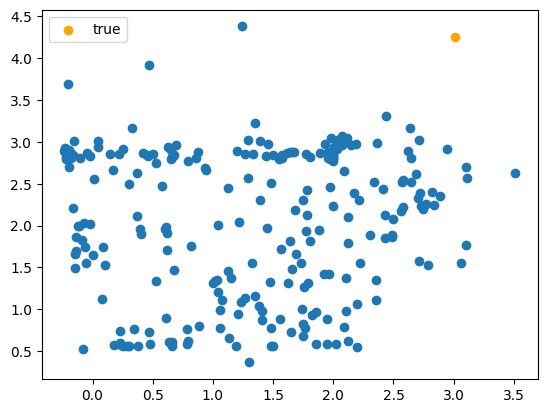

In [ ]:
plt.scatter(init_sample_discrepancy_all[:,0],init_sample_discrepancy_all[:,1])  
real_dis = minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[-1]), X_response=real_response)
plt.scatter(real_dis[0][0],real_dis[0][1],color='orange',label='true')
plt.legend(loc=2)

plt.show()

sampling init value from less density area

In [86]:
lows=[0,-3,-3,-3,-2]
highs = [5,5,5,5,6]

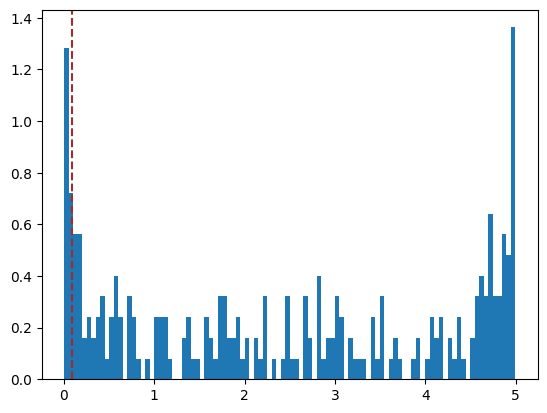

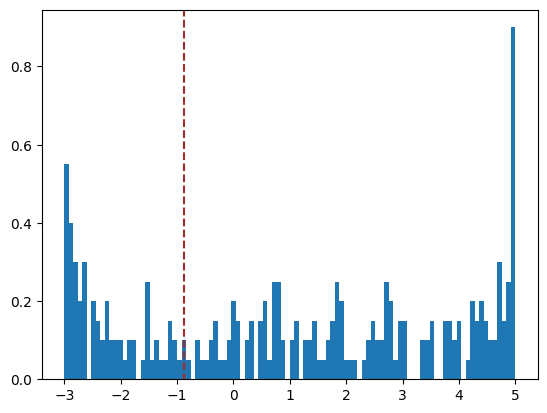

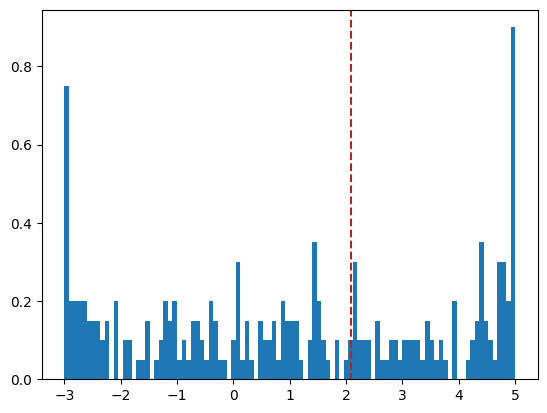

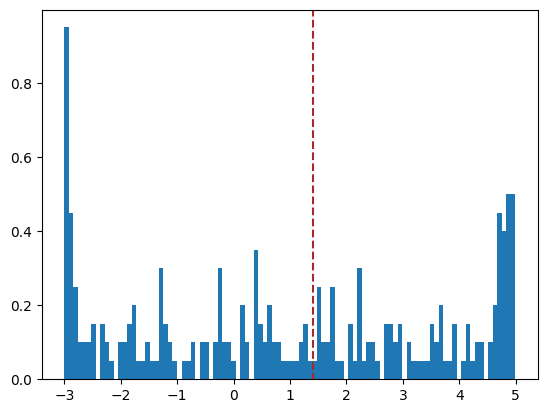

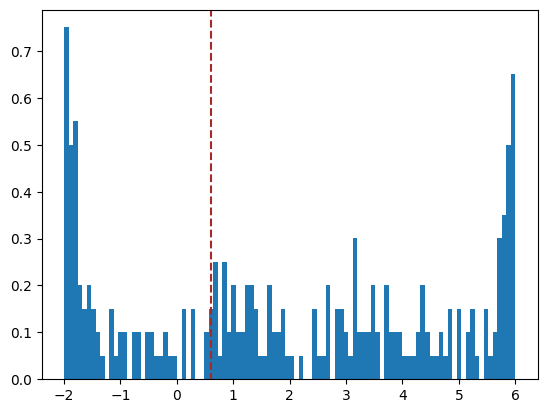

In [89]:
# Expected to be close to true param
l = [0,3,5,6,7]
for i in range(num_of_parameters):
    plt.hist(init_sample_theta_all[:,i],density=True, bins = 100)
    plt.axvline(real_theta[l[i]],lows[i],highs[i],linestyle="--",c='brown',label='$closed_form$')
    plt.show()

In [90]:
t_theta = init_sample_theta_all[np.argmax(init_sample_discrepancy_all[:,1]),:]
minus_simluated_discrepancy(theta=([t_theta[0], real_theta[1]], real_theta[2],[t_theta[2],t_theta[3]], [t_theta[1],real_theta[4]],t_theta[-1]), X_response=real_response)

array([[1.25522849, 4.26472327]])

In [91]:
t_theta = init_sample_theta_all[np.argmax(init_sample_discrepancy_all[:,0]),:]
minus_simluated_discrepancy(theta=([t_theta[0], real_theta[1]], real_theta[2],[t_theta[2],t_theta[3]], [t_theta[1],real_theta[4]],t_theta[-1]), X_response=real_response)

array([[3.56578691, 2.64015899]])

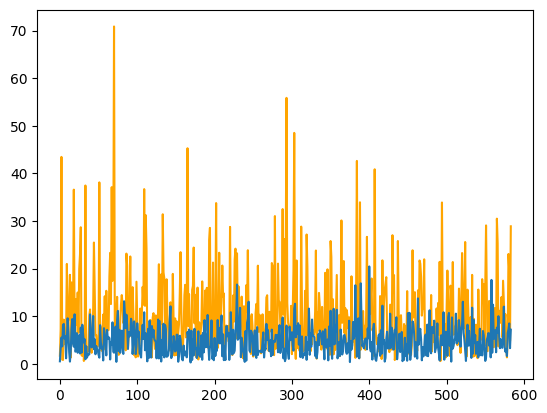

In [92]:

plt.plot(MLBA(X_attributes, lambdas=[t_theta[0],real_theta[1]], log_I0=real_theta[2],
                    betas=[t_theta[2],t_theta[3]],
                    deltas=[t_theta[1],real_theta[4]],
                    threshold=t_theta[-1])[0], color ='orange')


plt.plot(MLBA(X_attributes,lambdas=real_theta[0:2],log_I0=real_theta[2],
                    betas=real_theta[4:(4+number_of_attributes)],
                    deltas=real_theta[3:(3+number_of_alternatives-1)],
                    threshold=real_theta[-1])[0])

In [34]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform


In [ ]:
# # check if can conduct GPU calculation
# print(torch.cuda.is_available())  # Should return True
# print(torch.cuda.device_count())  # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU

True
1
NVIDIA GeForce RTX 3080


In [35]:
torch.set_default_dtype(torch.float32) #set tensor float precision 

In [161]:
# # # # ## used when retriving well-trained models
import pandas as pd
df_X = pd.read_csv("em_2048iter_1quantiletol_5_train_X_1115_logdis_250_v4.csv",header=None,dtype=np.float32)
df_Y = pd.read_csv("em_2048iter_1quantiletol_5_train_Y_1115_logdis_250_v4.csv",header=None,dtype=np.float32)
df_X = df_X.astype(np.float32)
df_Y = df_Y.astype(np.float32)
train_X = torch.from_numpy(df_X.to_numpy()).to(torch.float32)
train_Y = torch.from_numpy(df_Y.to_numpy()).to(torch.float32)

# df_X = pd.read_csv("em_1000iter_1quantiletol_5_train_X_1115_logdis_250_v3.csv",header=None)
# df_Y = pd.read_csv("em_1000iter_1quantiletol_5_train_Y_1115_logdis_250_v3.csv",header=None)

In [162]:
df_X.to_numpy()[:250+32,:]

array([[ 0.        , -3.        , -3.        , -3.        , -2.        ],
       [ 0.        , -3.        , -3.        , -3.        ,  6.        ],
       [ 0.        , -3.        , -3.        ,  5.        , -2.        ],
       ...,
       [ 0.03931403, -1.5581541 ,  4.9790163 ,  2.1279144 ,  3.5013528 ],
       [ 4.9194303 , -2.9850323 , -2.9681602 , -2.572494  , -1.9751751 ],
       [ 2.8116252 ,  2.683447  , -0.5294496 , -0.11170924,  1.3843706 ]],
      dtype=float32)

In [163]:
## used when retriving well-trained models
init_sample_theta_all = df_X.to_numpy()[:250+32,:]
init_sample_discrepancy_all = df_Y.to_numpy()[:250+32,:]
print(pd.DataFrame(init_sample_discrepancy_all).describe())

                0           1
count  282.000000  282.000000
mean     1.250134    1.984591
std      0.955814    0.898586
min     -0.336572   -0.000172
25%      0.382894    1.174392
50%      1.337609    2.117163
75%      1.993025    2.833689
max      3.510779    4.376319


In [ ]:
# X = torch.from_numpy(init_sample_theta_all)
# Y = torch.from_numpy(init_sample_discrepancy_all)
# train_X = X.double()
# train_Y = Y.double()

In [39]:
list(init_sample_discrepancy_all.min(axis=0)-0.1)

[-0.43657172, -0.10017204]

In [40]:
print(pd.DataFrame(train_X).describe())

                 0            1            2            3            4
count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000
mean      2.458035     0.784508     0.459329     0.057505     0.831532
std       1.679908     2.130313     2.288678     2.525217     1.916827
min       0.000000    -3.000000    -3.000000    -3.000000    -2.000000
25%       1.000926    -0.541357    -1.477974    -2.093745    -0.163992
50%       2.420238     0.586744     0.346825    -0.378244     0.498075
75%       3.971299     2.128803     2.251583     1.725256     1.237514
max       5.000000     5.000000     5.000000     5.000000     6.000000


In [41]:
real_theta_u = [real_theta[0],real_theta[3],real_theta[5],real_theta[6],real_theta[-1]]  
real_theta_u  

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [42]:
lows_u = [0,-3,-3,-3,-2]
highs_u = [5,5,5,5,6]


In [42]:
df = pd.DataFrame(train_Y)
df.describe()

0            1
count  2048.000000  2048.000000
mean      2.325843     2.552294
std       1.054215     0.773784
min      -0.336572    -0.000172
25%       1.711761     2.150170
50%       2.744071     2.809052
75%       3.194158     3.017252
max       3.594561     5.023626

In [ ]:
#  GPU training setting
# device_gpu = torch.device("cuda:0")
# device_cpu = torch.device("cpu")
# # Optimize acquisition function on CPU
# # Step 1: Evaluate the acquisition function on GPU and transfer to CPU
# def evaluate_acqf_on_cpu(acq_function, bounds, **kwargs):
#     # Wrap the GPU acquisition function in a CPU-compatible function
#     def wrapped_acq_function(X):
#         X_gpu = X.to(device_gpu)  # Move inputs to GPU
#         with torch.no_grad():
#             return acq_function(X_gpu).to(device_cpu)  # Return outputs on CPU

#     return optimize_acqf(wrapped_acq_function, bounds=bounds, **kwargs)

In [ ]:
ref_point = list(init_sample_discrepancy_all.min(axis=0)-0.1)
bounds = torch.tensor([lows_u,highs_u],dtype=torch.float32)

In [ ]:
# retrieve GP model based on train_X and train_Y, can skip the next chunk for model replication 

# gp = SingleTaskGP(train_X, train_Y)
# print(f"gp is finished")
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
# print(f"mll is finished")
# # ---------------------
# fit_gpytorch_mll(mll)

In [ ]:
import time
import pickle
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 1048# increase it until prediction discrepancy decreases 300

## GPU allocation
# train_X = train_X.to(device_gpu)
# train_Y = train_Y.to(device_gpu)


for i in range(number_of_iterGPtraining):
    
    qr = 0
    qr2 = 0.3
    top = 20  
    # --------------------- GPU computing
    ## For each iteration, train the GP model using current training data
    # gp = SingleTaskGP(train_X, train_Y).to(device_gpu)
    # print(f"gp is finished")
    # mll = ExactMarginalLogLikelihood(gp.likelihood, gp).to(device_gpu)
    # print(f"mll is finished")
    
    # --------------------- CPU computing
    gp = SingleTaskGP(train_X, train_Y)
    # print(f"gp is finished")
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    # print(f"mll is finished")
    
    # ---------------------
    
    fit_gpytorch_mll(mll)
    print(f"mll is fitted")
    # Define the acuisition function using current training data
    qNEHVI = qNoisyExpectedHypervolumeImprovement(gp, ref_point, train_X)
    print(f"qNEHVI is finished")
    ##CPU
    candidate, acq_value = optimize_acqf(qNEHVI, bounds=bounds, q=1, num_restarts=10, raw_samples=320,)
    # candidate, acq_value = evaluate_acqf_on_cpu(qNEHVI, bounds=bounds, q=1, num_restarts=10, raw_samples=256,)
    print(f"optimization is finished")
    # reject aquisition points if real discrepancy is too large


    # Include new acuisition into training data
    candidate = candidate.to(torch.float32)
    candidate_X = candidate.flatten().numpy()
    

    candidate_Y = minus_simluated_discrepancy(theta = ([candidate_X[0],  real_theta[1]], real_theta[2],[candidate_X[2],candidate_X[3]],
                                                    [candidate_X[1],real_theta[4]], candidate_X[-1]),X_response=real_response)
                                       
    candidate_Y = torch.from_numpy(candidate_Y).to(torch.float32)
    
    

    train_X = torch.cat((train_X, candidate)).to(torch.float32)
    train_Y = torch.cat((train_Y, candidate_Y)).to(torch.float32)

        
    # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
    if i % 1 == 0:
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))

    if (i+1+8)%20==0:
        df_X = pd.DataFrame(train_X.detach().numpy())
        df_X.to_csv(f"em_"+str(2040+i+1+8)+"iter_1quantiletol_5_train_X_1115_logdis_250_v4.csv",header=False,index=False)
        df_Y = pd.DataFrame(train_Y.detach().numpy())
        df_Y.to_csv(f"em_"+str(2040+i+1+8)+"iter_1quantiletol_5_train_Y_1115_logdis_250_v4.csv",header=False,index=False)
    
        

print(f"Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


Running time for GP training: --- 0.0005910396575927734 seconds ---


In [49]:
torch.quantile(train_Y,q=0.8,dim=0).tolist()

[3.244387149810791, 3.067241668701172]

In [45]:
df = pd.DataFrame(train_Y)  
df.describe()

0            1
count  2048.000000  2048.000000
mean      2.325843     2.552294
std       1.054215     0.773784
min      -0.336572    -0.000172
25%       1.711761     2.150170
50%       2.744071     2.809052
75%       3.194158     3.017252
max       3.594561     5.023626

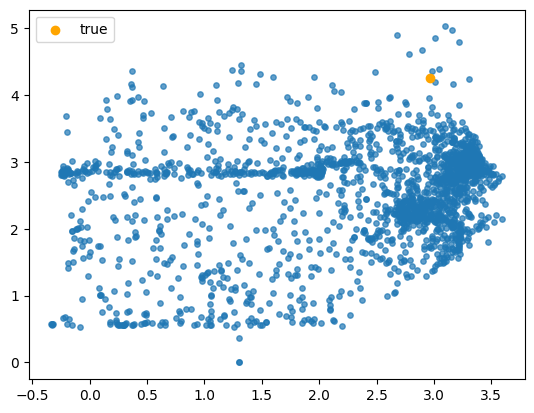

In [46]:
# Expectedly, training data should cover the neighborhood of true param simulation's discrepancy point
real_dis = minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[-1]), X_response=real_response)
plt.scatter(train_Y[:,0],train_Y[:,1],alpha = 0.7,s = 15)
plt.scatter(real_dis[0][0],real_dis[0][1],color='orange',label='true')
# plt.xlim(-1,0)
plt.legend(loc=2)
plt.show()

In [53]:
df = pd.DataFrame(train_X)
df.describe()

0            1            2            3            4
count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000
mean      2.458035     0.784508     0.459329     0.057505     0.831532
std       1.679908     2.130313     2.288678     2.525217     1.916827
min       0.000000    -3.000000    -3.000000    -3.000000    -2.000000
25%       1.000926    -0.541357    -1.477974    -2.093745    -0.163992
50%       2.420238     0.586744     0.346825    -0.378244     0.498075
75%       3.971299     2.128803     2.251583     1.725256     1.237514
max       5.000000     5.000000     5.000000     5.000000     6.000000

In [ ]:
training_results = np.zeros((train_Y.size()[0], 6))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood1 = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][0]).log_prob(real_obj[0])
    botorchlikelihood2 = torch.distributions.Normal(loc=pred_obj[0][1], scale=pred_var[0][1]).log_prob(real_obj[1])
    botorchlikelihood = botorchlikelihood1+botorchlikelihood2
    training_results[i,:] = [i,real_obj[0].item(),real_obj[1].item(),pred_obj[0][0].item(),pred_obj[0][1].item(),botorchlikelihood.item()]

training_results

array([[ 0.00000000e+00,  2.72580600e+00,  2.28881288e+00,
         2.70701265e+00,  2.28676772e+00, -8.16579971e+01],
       [ 1.00000000e+00, -1.55626461e-01,  1.96094239e+00,
        -1.53217912e-01,  1.96069312e+00,  8.02321243e+00],
       [ 2.00000000e+00, -3.23849320e-01,  5.70513666e-01,
        -3.07002902e-01,  7.73296416e-01, -1.39634369e+02],
       ...,
       [ 2.04500000e+03,  3.22840929e+00,  2.60573626e+00,
         3.21790290e+00,  2.63076615e+00, -5.57851839e+00],
       [ 2.04600000e+03,  1.59838402e+00,  1.04251301e+00,
         1.59661102e+00,  1.10806239e+00, -9.49183655e+00],
       [ 2.04700000e+03,  2.75672483e+00,  2.31601334e+00,
         2.75825405e+00,  2.31229210e+00,  8.36077690e+00]])

In [56]:
df = pd.DataFrame(training_results)
df.describe()

0            1            2            3            4  \
count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000   
mean   1023.500000     2.325843     2.552295     2.325852     2.552305   
std     591.350996     1.054215     0.773784     1.051788     0.759698   
min       0.000000    -0.336572    -0.000172    -0.326581     0.048648   
25%     511.750000     1.711761     2.150170     1.704501     2.154976   
50%    1023.500000     2.744071     2.809052     2.746347     2.794949   
75%    1535.250000     3.194158     3.017252     3.197900     3.017608   
max    2047.000000     3.594561     5.023626     3.567125     4.523444   

                  5  
count   2048.000000  
mean    -261.158344  
std     2191.368303  
min   -68902.921875  
25%      -61.556994  
50%       -5.101039  
75%        6.596928  
max       10.320192

In [57]:
num_init_samples = 250+32

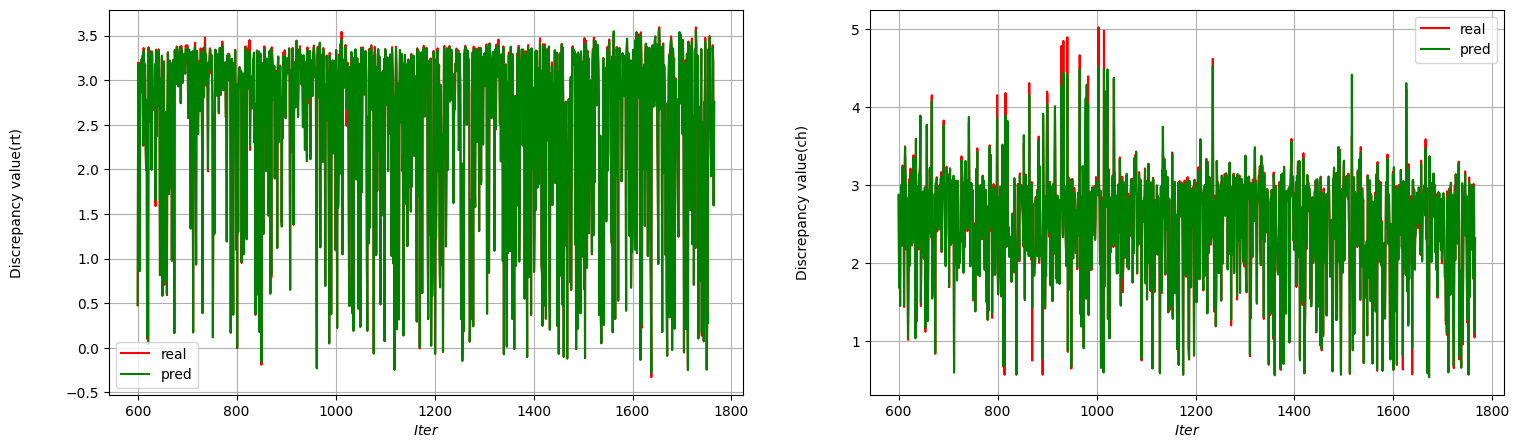

In [58]:
# Draw training curves
# Two curves should almost match together, menaing accurate prediction
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 2, figsize=(18,5))
axs[0].plot(training_results[num_init_samples+600:,0]-num_init_samples, training_results[num_init_samples+600:,1], color='red', label='real')
axs[0].plot(training_results[num_init_samples+600:,0]-num_init_samples, training_results[num_init_samples+600:,3],'green',label='pred')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].tick_params(axis='both', labelsize=fs)
axs[0].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[0].set_ylabel(r'Discrepancy value(rt)',fontsize=font_size_text,rotation='vertical',labelpad=30)

axs[1].plot(training_results[num_init_samples+600:,0]-num_init_samples, training_results[num_init_samples+600:,2], color='red', label='real')
axs[1].plot(training_results[num_init_samples+600:,0]-num_init_samples, training_results[num_init_samples+600:,4],'green',label='pred')
axs[1].legend(loc=1,fontsize=fs)
axs[1].grid()
axs[1].tick_params(axis='both', labelsize=fs)
axs[1].set_xlabel(r'$Iter$',fontsize=font_size_text)
axs[1].set_ylabel(r'Discrepancy value(ch)',fontsize=font_size_text,rotation='vertical',labelpad=30)


plt.show()

In [ ]:
# Can skip the next two chuck for model replication
# cov_est_noise = np.loadtxt('mobolfi_em_2048iter_cov_est_noise_5_1115_logdis_v4.txt', dtype=np.dtype('float64'))

In [ ]:
def dis_fun(theta,row):
    return(minus_simluated_discrepancy(theta=theta)[0])

Y_cov = np.zeros((100,number_of_discrepancies))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
theta = ([X_cov[0],real_theta[1]], real_theta[2],[X_cov[2],X_cov[3]],[X_cov[1],real_theta[4]], X_cov[-1])

Y_cov = Parallel(n_jobs=-1)(delayed(dis_fun)(theta,row) for row in range(100))
cov_est_noise = np.cov(Y_cov, rowvar = False)

In [85]:
cov_est_noise = np.array([[4.95244129e-04, 3.47207021e-06],
        [3.47207021e-06, 8.23311515e-04]])

In [ ]:
cov_est_noise

array([[4.95244129e-04, 3.47207021e-06],
       [3.47207021e-06, 8.23311515e-04]])

In [46]:
# An optinal solution to find correlation between output dimensions (rt and ch)
# Estimate the correlation separately by applying covariance formula ot train_Y
cov_est_output = np.cov(train_Y, rowvar = False)
cov_est_output

array([[1.11136887, 0.21179442],
       [0.21179442, 0.59874135]])

One thing worth to meantion is that the estimated covariance $Σ$, has small values. That suggest the 2 data courses (rt and ch) simulated by MLBA have noise uncorrelated from each other, i.e. the noise from 2 data sources come from 2 independent places.

As iteration goes, it is clear to see the predictive discrepancies values are decreasing and gradually going to the real data average, which is expected to see in theory.

But a good surrogate is not our ultimate target, we want "good" params that attain high likelihood values, and generate high similarity data, i.e. discrepancies very small.

So, the next step is to infer params and test their performance.

**Parameter inference and performance test**

After training the model, we need to compute the approximate posterior function. (See the original BOLFI paper)

Then, we need to draw MCMC sample parameters from the approximate posterior distribution. And draw plots of marginal posterior for each parameter.

Finally, we are going to test performance of parameter inference, by picking up a parameter point at high posterior density value, simluated multiple datasets given that parameter and present its similarity with real data.

In [ ]:
# Can skip the next two chuck for model replication
# tol = np.loadtxt('mobolfi_em_2048iter_1quantiletol_5_1115_logdis_v4.txt', dtype=np.dtype('float64'))

In [49]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is p(y_obs|theta), we have no means to compute likelihood for y!=y_obs, because GP model is trained by y_obs

tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)


from scipy.stats import multivariate_normal

def approximate_log_likelihood(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([[variances[0][0].item(),covariance],
                    [covariance,variances[0][1].item()]])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0],-tol[1]])]).reshape(-1)
  log_likelihood = log_likelihood.float()
  return log_likelihood
# [3.473558187484741, 4.164658546447754]

[3.473558187484741, 4.164658546447754]


In [48]:
print(approximate_log_likelihood(theta=train_X[-3,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package  
print(approximate_log_likelihood(theta=train_X[-2,:].view(-1)) )
print(approximate_log_likelihood(theta=train_X[-1,:].view(-1)) )

print(train_Y[-3,:].view(-1)) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package  
print(train_Y[-2,:].view(-1))
print(train_Y[-1,:].view(-1))

tensor([-165.7437])
tensor([-inf])
tensor([-231.4428])
tensor([3.2284, 2.6057])
tensor([1.5984, 1.0425])
tensor([2.7567, 2.3160])


c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:862: RuntimeWarning: divide by zero encountered in log
  out = np.log(cdf)


In [49]:
minus_simluated_discrepancy(theta=([train_X[-1,0],real_theta[1]], real_theta[2],[train_X[-1,2],train_X[-1,3]], [train_X[-1,1],real_theta[4]],train_X[-1,-1]), X_response=real_response)

array([[2.74742806, 2.30236111]])

In [50]:
real_theta_u =[real_theta[0]]#real_theta[0:1]
real_theta_u.append(real_theta[3])
real_theta_u.extend(real_theta[5:8])

real_theta_u #lamda1, delta1, beta,chi

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [51]:
# -23.2730
approximate_log_likelihood(theta=torch.Tensor(real_theta_u).view(-1)) # should be large and larger than value of the chunk above

tensor([-23.2730])

In [105]:
test_theta = [1,  -2,np.log(33.54),  np.log(25.5),3]

In [106]:
approximate_log_likelihood(theta=torch.Tensor(test_theta).view(-1))

tensor([-35.3105])

In [107]:
minus_simluated_discrepancy(theta=([test_theta[0], real_theta[1]], real_theta[2],[test_theta[2],test_theta[3]], [test_theta[1],real_theta[4]],test_theta[-1]), X_response=real_response)

array([[0.72559412, 2.79641124]])

In [108]:
minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]], [real_theta[3],real_theta[4]],real_theta[-1]), X_response=real_response)

array([[2.98986914, 4.23161723]])

In [109]:
real_theta_u 

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [51]:
lls = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    lls[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(lls)
crt_median = df_describe.median()
print(df_describe.describe())
test_theta = train_X[np.argmax(lls),:]
test_theta 

c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:862: RuntimeWarning: divide by zero encountered in log
  out = np.log(cdf)


                 0
count  2048.000000
mean          -inf
std            NaN
min           -inf
25%    -712.756180
50%    -298.499847
75%    -180.808475
max     -11.026801


tensor([ 0.0000, -2.0386,  2.3501,  1.4304,  0.3379])

The prior density is defined to be porduct of each marginal priors (assume parameters are indep).

However, the prior product is too small compared with approximate likelihood value. This is because the approximate likelihood function is merely proportional to real likelihood, we don't know the level of proximity to real likelihood. Thus, to enhance the voice of prior, we times a constant with the log prior density to make its values within the similar scale with approximate likelihood

In [53]:
print(real_theta_u)
print(test_theta )
# lam1,delta1,beta1,beta2,chi
# [0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]
# tensor([ 0.0000, -1.5367,  1.6991,  1.2004,  0.0328], dtype=torch.float64)
# tensor([ 0.0000, -2.0979,  2.2644,  1.3458,  0.0723], dtype=torch.float64)


[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]
tensor([ 0.0000, -2.0386,  2.3501,  1.4304,  0.3379])


In [52]:
lows_u_prior = [0, -3, -3,  -3,-2]
highs_u_prior = [5,5 , 5, 5, 6]

In [53]:
def log_prior(theta):# theta is 1d tensor
    
    # print(np.where((theta.tolist()-lows)>=0,[0]*num_of_parameters,[1]*num_of_parameters))
    # print(np.where((theta.tolist()<=highs),[0]*num_of_parameters,[1]*num_of_parameters))
    # if np.sum(np.where((theta.tolist()>=lows),[0]*num_of_parameters,[1]*num_of_parameters))+np.sum(np.where((theta.tolist()<=highs),[0]*num_of_parameters,[1]*num_of_parameters)) > 0:
    lp = 0
    for i in range(theta.size()[0]):
        if theta[i]<lows_u_prior[i] or theta[i]>highs_u_prior[i]:
            lp = torch.Tensor([-1e12])[0]
            return torch.Tensor([-1e12])[0]
    

    # lp = (lp_log_lambda1+lp_beta1+lp_beta2+lp_beta3+lp_delta1+lp_threshold)
    
    
    return lp

In [60]:
#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


0
count  2048.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0

In [59]:
def approximate_log_posterior(theta):
  ll = approximate_log_likelihood(theta)
  lprior = log_prior(theta)
  lp = lprior + ll #- crt_median
  lp = lp.float()
  return lp

In [56]:
print(approximate_log_posterior(theta=torch.Tensor(real_theta_u).view(-1)))# ([-12.6231] #[-14.8885]  #([-30.4111]
print(approximate_log_posterior(theta=torch.Tensor(test_theta).view(-1)))

tensor([-23.2730])
tensor([-11.0268])


In [58]:
approximate_log_posterior(theta = torch.Tensor([0.9,  -45.09966857731342,np.log(33.537153247743845), np.log(82.99378249794245), np.log(25.564981531351805)]))#-1.1013

tensor([-1.0000e+12])

In [59]:
tr_theta = list(real_theta_u)
# tr_theta[2] = 2.5 
minus_simluated_discrepancy(theta=([tr_theta[0],real_theta[1]], real_theta[2],[tr_theta[2],tr_theta[3]], [tr_theta[1],real_theta[4]],tr_theta[-1]), X_response=real_response) #[[-0.20041665, -0.14917774]])

array([[3.03966927, 4.23254599]])

In [60]:
tr_theta = list(test_theta)
minus_simluated_discrepancy(theta=([tr_theta[0],real_theta[1]], real_theta[2],[tr_theta[2],tr_theta[3]], [tr_theta[1],real_theta[4]],tr_theta[-1]), X_response=real_response)

array([[3.33979748, 4.18929006]])

In [ ]:
gp.posterior(torch.from_numpy(np.array([real_theta_u])).to(torch.float32)).mean
# [[2.9904523, 4.1726003]] real
# [[2.6162, 3.3914]]



tensor([[2.6162, 3.3914]], grad_fn=<TransposeBackward0>)

In [122]:
gp.posterior(train_X[np.argmax(lls),:].view(1,-1)).mean #[[-0.1749, -0.2241]]

tensor([[3.2811, 4.3064]], grad_fn=<TransposeBackward0>)

In [ ]:
test_theta = train_X[np.argmax(lls),:]
print(test_theta)
print(real_theta_u)

tensor([ 0.0000, -2.0386,  2.3501,  1.4304,  0.3379])
[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]


In [ ]:
lows_u = [0, -3, -3, -3, -2]
highs_u = [5, 5, 5, 5, 6]

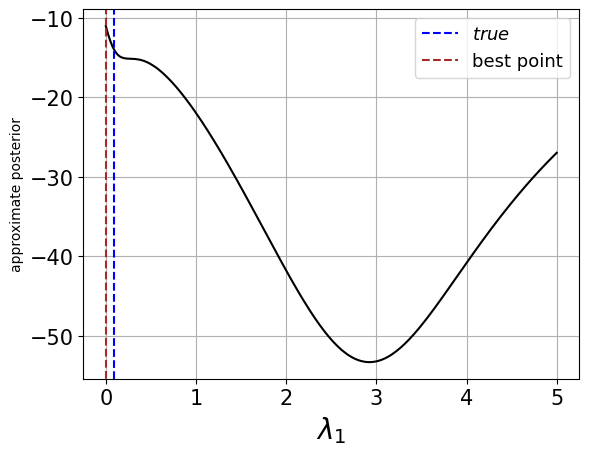

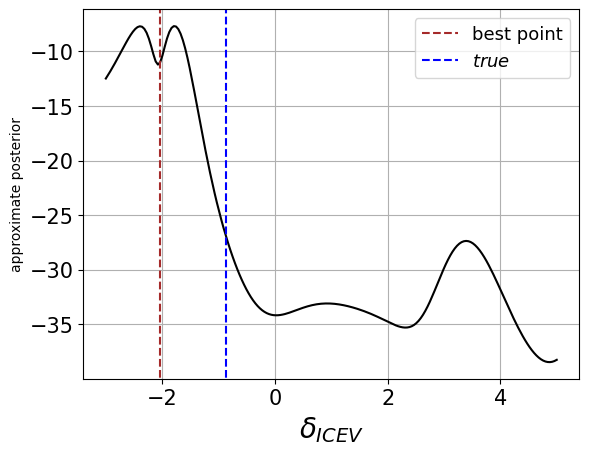

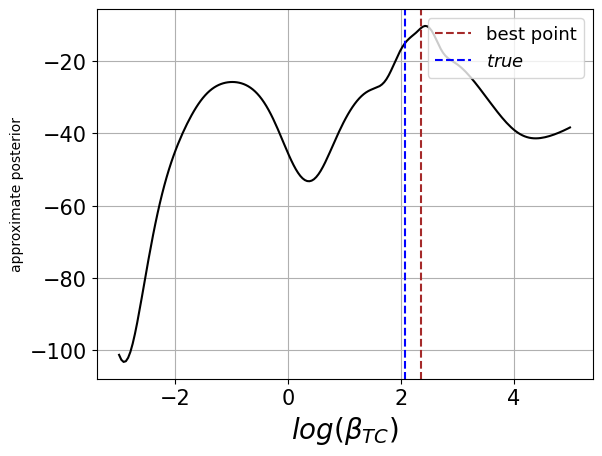

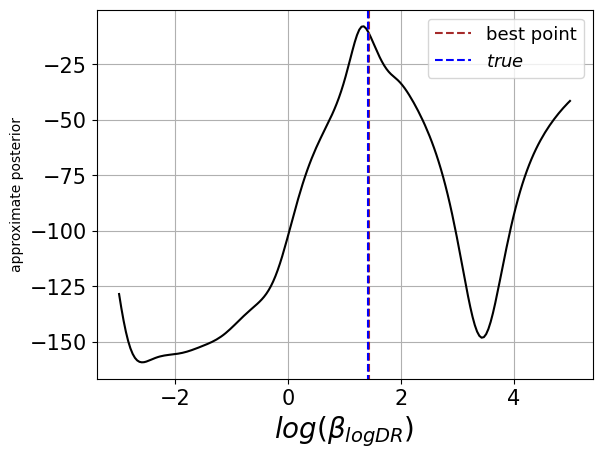

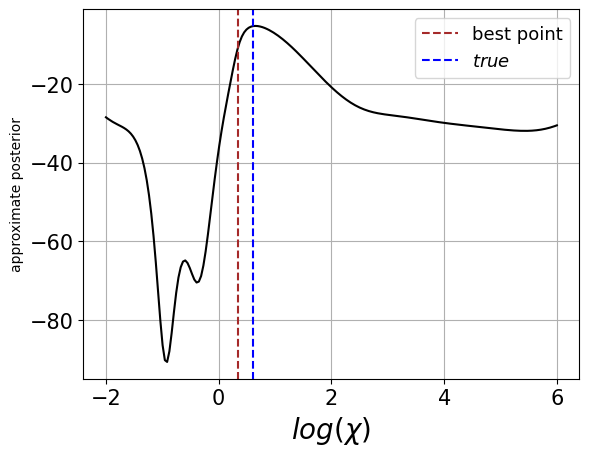

In [ ]:
num_of_parameters = 5
import matplotlib.pyplot as plt 
import seaborn as sns

param_list = [r'$\lambda_1$',r'$\delta_{ICEV}$',r'$log(\beta_{TC})$',r'$log(\beta_{log DR})$',r'$log (\chi)$']
for param_index in range(num_of_parameters):
    shift_thetas = np.linspace(lows_u[param_index],highs_u[param_index], 200)

    shift_marlls = np.zeros(200)


    for i in range(200):
      
        tr_theta =list(test_theta)#list(real_theta_u) # list(last_chain_joint[0,:-1])
        tr_theta[param_index] = shift_thetas[i]
        shift_marlls[i] = approximate_log_posterior(torch.Tensor(tr_theta).view(-1)).item()
       
   
   
  
    

    plt.plot(shift_thetas,shift_marlls, color="black")
    plt.axvline( real_theta_u[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='blue',label='$true$')
    plt.axvline(test_theta[param_index],-3,2,linestyle="--",c='brown',label = "best point")
        
 
        

    
    plt.legend()
    
    
    plt.legend(fontsize=13,loc='upper right')
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[param_index],fontsize=20)
    plt.ylabel("approximate posterior")
    #plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_joint_'+param_name[param_index]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()
  



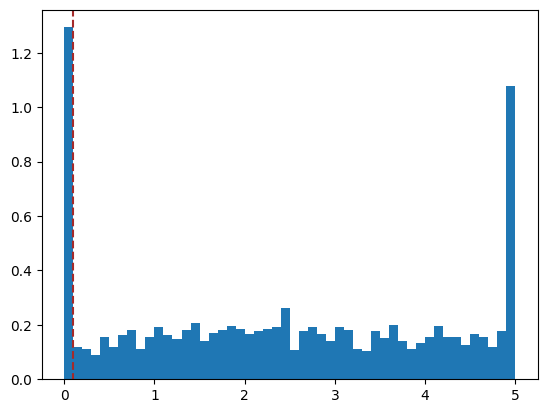

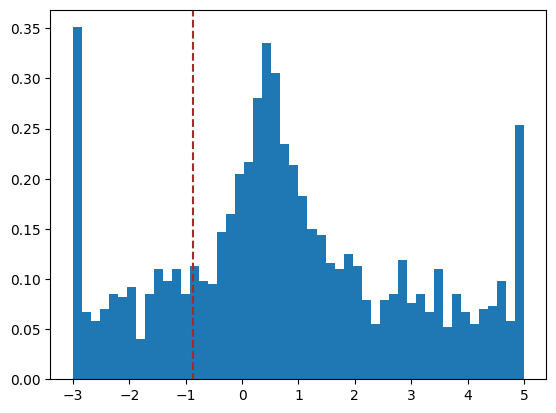

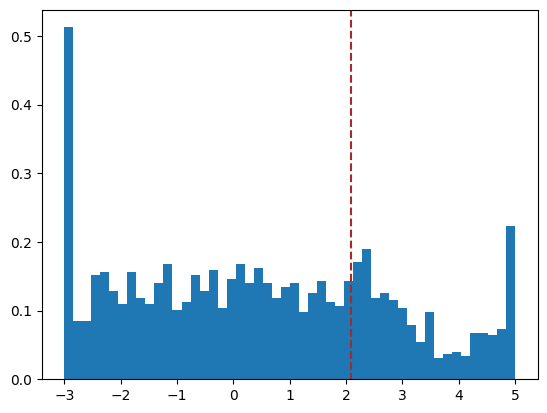

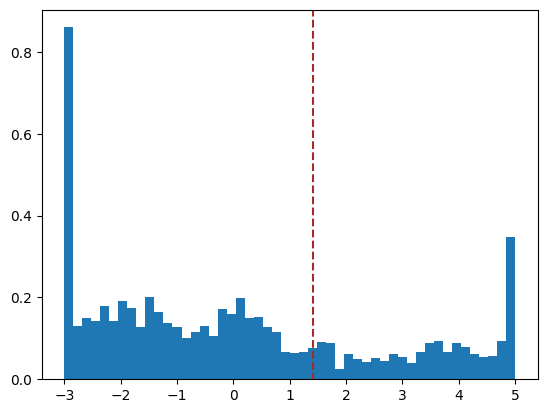

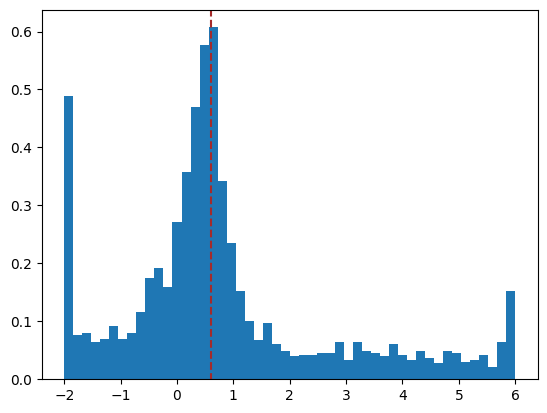

In [64]:
for i in range(num_of_parameters):
    plt.hist(train_X[:,i].detach().numpy(),density=True,bins =50)
    plt.axvline(real_theta_u[i],lows_u[param_index],highs_u[param_index],linestyle="--",c='brown',label='$true$')
    plt.show()

In [66]:
# Marginal approximate llk

tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)

def approximate_log_likelihood_rt(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][0]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item1 = (-tol[0]-means[0][0])/torch.sqrt(variances[0][0]+torch.Tensor(cov_noise)[0][0])
  prob1 = 0.5 * (1 + torch.erf(item1 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob1).float()
  return log_likelihood

def approximate_log_likelihood_ch(theta,tol=tol,cov_noise=cov_est_noise,gp=gp):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  if torch.isnan(means[0][1]):
      return torch.from_numpy(np.array(-np.Inf).reshape(-1))
  means = means * -1
  item2 = (-tol[1]-means[0][1])/torch.sqrt(variances[0][1]+torch.Tensor(cov_noise)[1][1])
  prob2 = 0.5 * (1 + torch.erf(item2 / torch.sqrt(torch.tensor(2))))
  log_likelihood = torch.log(prob2).float()
  return log_likelihood

[3.473558187484741, 4.164658546447754]


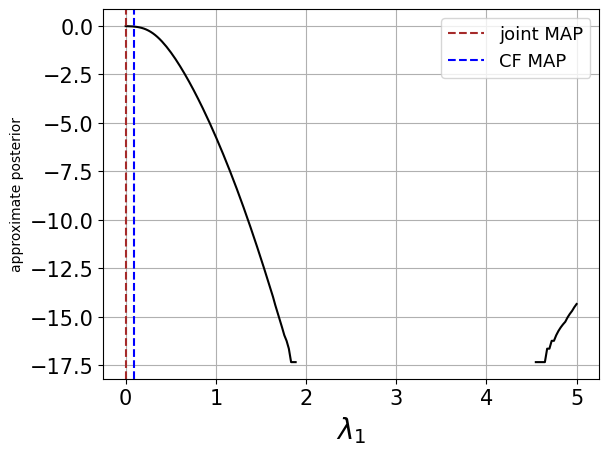

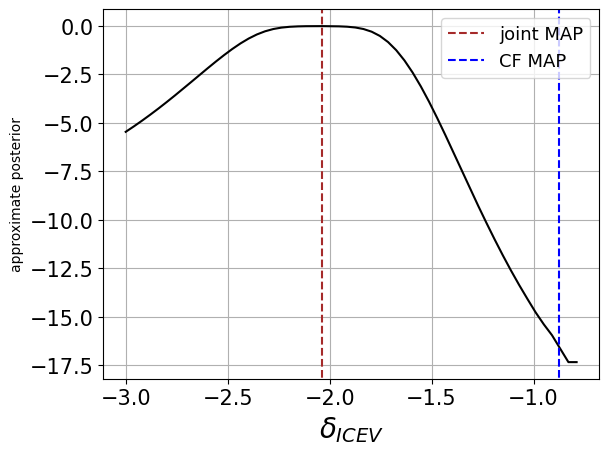

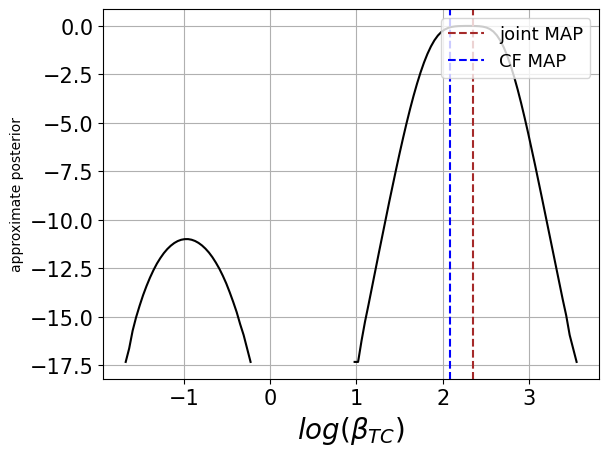

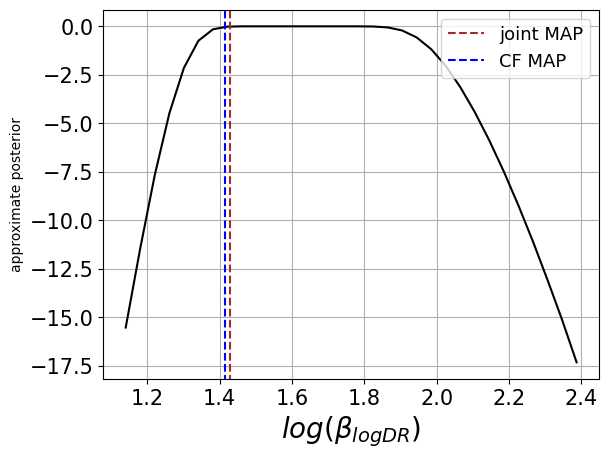

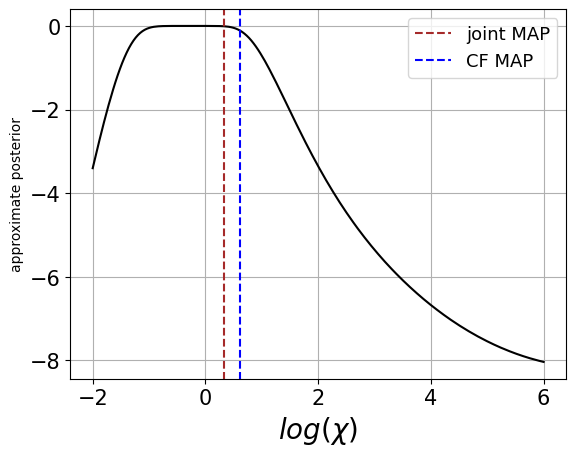

In [ ]:
lows_u = [0,-3,-3,-3,-2]
highs_u = [5,5,5,5,6] 

for param_index in range(num_of_parameters):
    shift_thetas = np.linspace(lows_u[param_index],highs_u[param_index], 200)

    shift_marlls = np.zeros(200)


    for i in range(200):
      
        tr_theta = list(test_theta)
        tr_theta[param_index] = shift_thetas[i]
        shift_marlls[i] = approximate_log_likelihood_ch(torch.Tensor(tr_theta).view(-1)).item()
       

    plt.plot(shift_thetas,shift_marlls, color="black")
    plt.axvline(test_theta[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='brown',label = "joint MAP")
    plt.axvline( real_theta_u[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='blue',label='CF MAP')

  
    plt.legend()
    
    
    plt.legend(fontsize=13,loc='upper right')
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[param_index],fontsize=20)
    plt.ylabel("approximate posterior")
    # plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_ch_'+param_name[param_index]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()
  


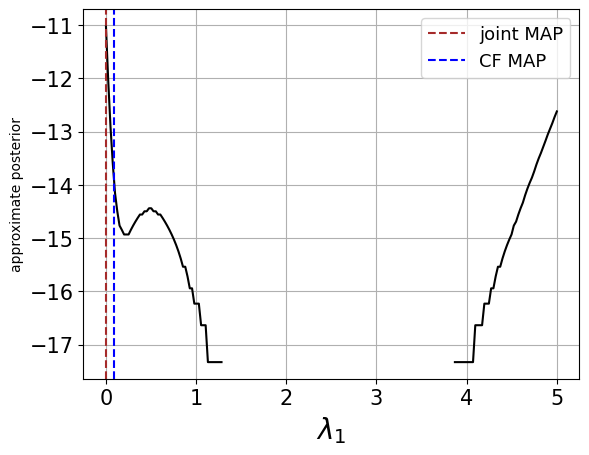

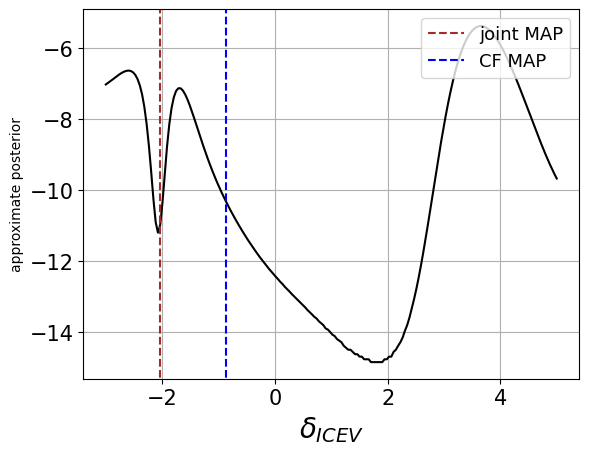

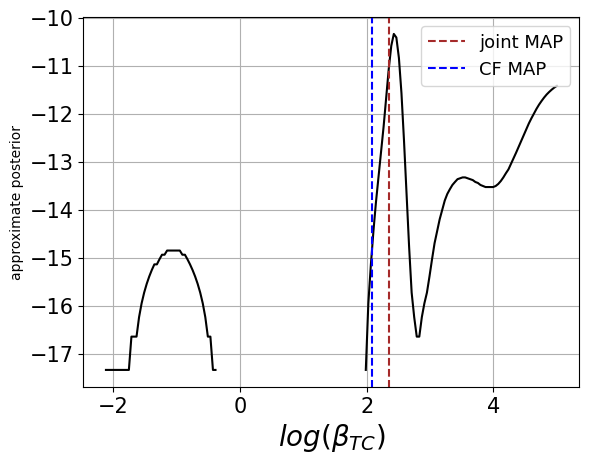

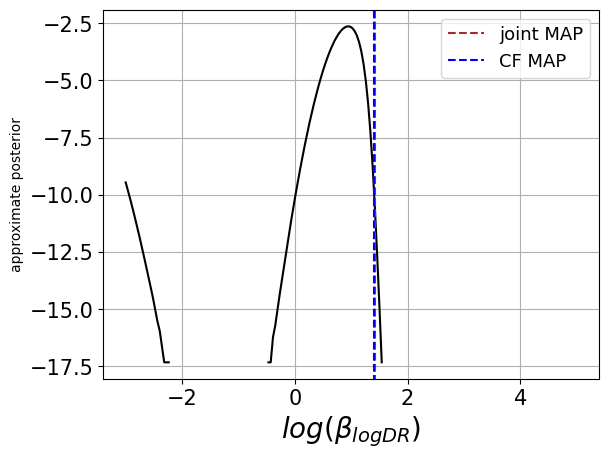

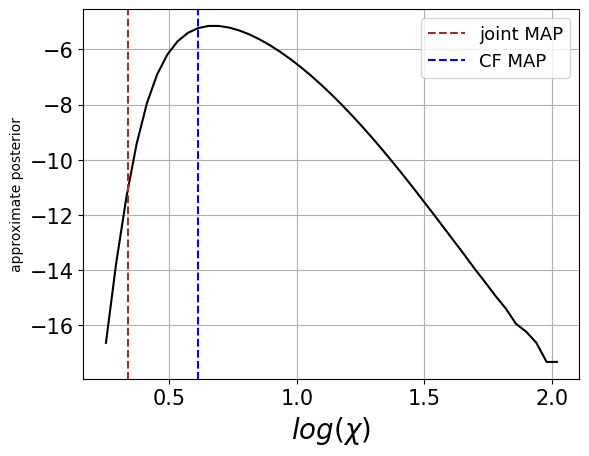

In [ ]:
param_list = [r'$\lambda_1$',r'$\delta_{ICEV}$',r'$log(\beta_{TC})$',r'$log(\beta_{log DR})$',r'$log (\chi)$']
for param_index in range(num_of_parameters):
    shift_thetas = np.linspace(lows_u[param_index],highs_u[param_index], 200)

    shift_marlls = np.zeros(200)


    for i in range(200):
      
        tr_theta = list(test_theta)
        tr_theta[param_index] = shift_thetas[i]
        shift_marlls[i] = approximate_log_likelihood_rt(torch.Tensor(tr_theta).view(-1)).item()

    plt.plot(shift_thetas,shift_marlls, color="black")
    plt.axvline(test_theta[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='brown',label = "joint MAP")
    plt.axvline( real_theta_u[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='blue',label='CF MAP')

    plt.legend()
    
    
    plt.legend(fontsize=13,loc='upper right')
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[param_index],fontsize=20)
    plt.ylabel("approximate posterior")
    # plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_rt_'+param_name[param_index]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()

In [ ]:
print(approximate_log_likelihood_rt(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above
print(approximate_log_likelihood_rt(theta=torch.Tensor(test_theta).view(-1))) # should be large and larger than value of the chunk above
print(approximate_log_likelihood_ch(theta=train_X[-1,:].view(-1))) #Input is defined to be 1d tensor theta, which satisfies need of MCMC package
print(approximate_log_likelihood_ch(theta=torch.Tensor(real_theta_u).view(-1))) # should be large and larger than value of the chunk above


likelihoods_rt = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_rt[i] = approximate_log_likelihood_rt(param)

df_describe = pd.DataFrame(likelihoods_rt)
print(df_describe.describe())

likelihoods_ch = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    likelihoods_ch[i] = approximate_log_likelihood_ch(param)

df_describe = pd.DataFrame(likelihoods_ch)
print(df_describe.describe())


def approximate_log_posterior_rt(theta):
  ll = approximate_log_likelihood_rt(theta)
  lprior = log_prior(theta)
  lp = lprior + ll #- prior_median.item() why we need to abstract such item
  lp = lp.float()
  return lp

def approximate_log_posterior_ch(theta):
  ll = approximate_log_likelihood_ch(theta)
  lprior = log_prior(theta)
  lp = lprior + ll #- prior_median.item()
  lp = lp.float()
  return lp

tensor(-inf, grad_fn=<LogBackward0>)
tensor(-8.4438, grad_fn=<LogBackward0>)
tensor(-11.0169, grad_fn=<LogBackward0>)
tensor(-inf, grad_fn=<LogBackward0>)
tensor(-14.8438, grad_fn=<LogBackward0>)


c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


                 0
count  2048.000000
mean          -inf
std            NaN
min           -inf
25%            NaN
50%            NaN
75%     -17.328680
max      -0.024889
            0
count  2048.0
mean     -inf
std       NaN
min      -inf
25%       NaN
50%       NaN
75%       NaN
max       0.0


c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


DeMCMC

In [75]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm
import csv

class DEMCMC:

    def __init__(self, param_prior, param_hyper, post_fun, post_type,
                 param_num, chain_num, iter_num,
                 burn_in, migrate_rate, gamma, epsilon_b):
        """
        :param param_prior: a list of strings. list length should be the same as param_num.
                        Only two types prior distribution are available now.
                        "norm", for normal distribution prior.
                        "unif", for uniform distribution prior.
        :param param_hyper: a  (param_num,2) array. Entries are float type.
                        X[i,0] is the mean (or lower bound) of norm (uniform) distribution;
                        X[i,1] is the sd (or upper bound) of the norm (uniform) distribution;

        :param post_fun: a python function for posterior calculation

        :param post_type: bool type
                    post_type = 0, if the posterior returns from 0 to 1.
                    post_type = 1, if the posterior returns log-value.
        :param post_module: string
                    name of module contains the posterior function
        :param param_num: int type.
                    The number of estimable parameters. parameters with known fixed number were included.
        :param chain_num: int type.
                    The number of chains. When n<6,the chain_num = 24; otherwise, chain_num = 3*param_num.
        :param iter_num: int type.
                    The number of iteration.
        :param burn_in: int type.
                    The number of iteration for burn-in period. This part will discard for posterior sampling.
                    Moreover, migration step happens during burn-in period to facilitate convergence
        :param migrate_rate: float type. range from 0 to 1
                    The rate of migration step frequency during burn-in period.
        :param gamma: float type. A hyperparameter of De-MCMC crossover step. gamma = 2.38/sqrt(2*param_num)
        :param epsilon_b: float or vector type. A hyperparameter of De-MCMC crossover step. epsilon \sim uniform[-epsilon_b,epsilon_b]
        """

        self.param_num = param_num
        self.chain_num = chain_num
        self.iter_num = iter_num
        self.burn_in = burn_in
        self.migrate_rate = migrate_rate
        self.gamma = gamma
        self.epsilon_b = epsilon_b
        self.param_prior = param_prior
        self.param_hyper = param_hyper
        self.postfun = post_fun
        self.post_type = post_type


    def log_poster(self, theta):
        """
        :param theta: a list. input of posterior function
        :return: float type. the log-posterior for the dataset given input theta
        """
        
        # theta = torch.tensor(theta,dtype=torch.float32)
        
        if self.post_type:
            # log-posterior is directly used.
            res = self.postfun(theta)
            if np.isnan(res):
                res = -np.inf
                print("Warning: A log-posterior input is NaN. The system will drop it.")
            elif res < -1e11:
                res = -np.inf
                print("The log-posterior input is less than -1e11.")
        else:
            # log-posterior is calculated.
            if np.isnan(self.postfun):
                print("Warning: A posterior input is NaN. The system will drop it.")
                res = -np.inf
            elif self.postfun < 1e-16:
                print("The posterior input is less than 1e-16.")
                res = -np.inf
            else:
                res = np.log(self.postfun(theta))
        
        return np.float32(res)

    def draw_prior(self, num, prior, hyper):
        '''
        return the random draw from prior
        :param num: int type. the number of random samples.
        :param prior: a string,either "norm" or "unif"
        :param hyper: array(1,2).
                    hyper[0] = mean of norm distribution (or lower bound of uniform);
                    hyper[1] = sd of norm distribution (or upper bound of uniform);
        :return: an array (num,1).
        '''
        if prior == "norm":
            res = np.random.normal(loc=hyper[0], scale=hyper[1], size=num).astype(np.float32)
            # res = scipy.stats.truncnorm.rvs(a = (0-hyper[0])/hyper[1], b = (200-hyper[0])/hyper[1] , loc= hyper[0], scale=hyper[1],size = num)

        elif prior == "unif":
            res = np.random.uniform(low=hyper[0], high=hyper[1], size=num).astype(np.float32)
        else:
            print("error: the prior shape is unkown.")
            res = np.nan

        return np.float32(res)


    def initial_chains(self):
        """
        A function to return  for initial value
          :return: a list, whose first and only element is a (chain_num, param_num) matrix
        """
        # Initialize chains. The last column is for likelihood

        
        
        ###########################################################################
       
            
        # check input
        if (len(self.param_prior) != self.param_num) | (np.shape(self.param_hyper)[0] != self.param_num):
            print("error: The parameter prior or hyper input length is inconsistent with parameter number.")
            
        elif np.shape(self.param_hyper)[1] != 2:
            print("error: The dimension of hyperparameters are inconsistent with design, ",
                "please check `inital_chains` function for details.")
            
        else:
            theta_0 = np.zeros((self.chain_num, self.param_num + 1)).astype(np.float32)
            # calculate the log-posterior for chain_num parameter sets
            for i in range(self.param_num):
                    theta_0[:, i] = self.draw_prior(self.chain_num, self.param_prior[i], self.param_hyper[i, :]).tolist()
            
            
            for j in range(self.chain_num):
                theta_0[j,self.param_num] = self.log_poster(theta_0[j,:-1])
            

            index_p = [-1]*self.chain_num     
            index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
            
        
            index = []
            for j in index_p:
                if j>=0:
                    index.append(j)

            while len(index) > 0:
                for i in range(self.param_num):
                    theta_0[index, i] = self.draw_prior(len(index), self.param_prior[i], self.param_hyper[i, :]).tolist()
                    # print(theta_0[i,self.param_num])
                    # calculate the log-posterior for chain_num parameter sets
                for j in index:
                    theta_0[j,self.param_num] = self.log_poster(theta_0[j, :-1])

                
                index_p = [-1]*self.chain_num
                index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
                
                
                index = []
                for j in index_p:
                    if j >= 0:
                        index.append(j)
       
        return theta_0.astype(np.float32)


    def crossover_step(self, chain_index, last_step_chains):
        """
        For a given chain, randomly draw other two chains to get the difference value, the proposed value = chain_value + difference + epsilon
        :param chain_index: int type. The index of the updated chain at this step
        :param last_step_chains: A dataframe.
        :return: the value of chain of this step.It is a vector whose length is param_num+1.

        """
        # last_step_chains = last_step_chains
        # get the previous parameter values in this chain
        theta_prev = np.array(last_step_chains.iloc[chain_index, :-1])
        # Randomly draw two chain indices from all chains except the current chain
        prob = [1 / (self.chain_num - 1)] * self.chain_num
        prob[chain_index] = 0
        de_ChainIndex = np.random.choice(range(self.chain_num), size=2, replace=False, p=prob)

        theta_m = np.array(last_step_chains.iloc[de_ChainIndex[0], :-1])
        theta_n = np.array(last_step_chains.iloc[de_ChainIndex[1], :-1])

        # Generate new theta; here, there are npar parameters to estimate in total
        # epsilon = np.random.uniform(-self.epsilon_b, self.epsilon_b, self.param_num)
        
        epsilon = np.array([np.random.uniform(low, high, 1) for low, high in zip([-x for x in self.epsilon_b], self.epsilon_b)],dtype=np.float32).T

        
        theta_proposed = theta_prev + self.gamma * (theta_m - theta_n) + epsilon

        proposed_post = self.log_poster(theta_proposed)
        if np.isnan(proposed_post):  # avoid nan.
            proposed_post = -np.inf
        prev_post = last_step_chains.iloc[chain_index, self.param_num]

        # Acceptance rate
        alpha = np.random.uniform()
        ratio = proposed_post - prev_post
        if np.isnan(ratio):
            print("Warning: please check the initial matrix.")
            ratio = -1
        elif np.isinf(ratio) | (ratio <= -1e12):
            ratio = -1
        else:
            ratio = np.exp(ratio)
        if alpha > ratio:
            # reject the proposed value
            temp = np.append(theta_prev, prev_post)

        else:
            temp = np.append(theta_proposed, proposed_post)

        return temp.astype(np.float32)



    def migration_step(self, last_step_chains):

        """
        migration step is optional for De-MCMC, but very useful for the convergence.
        Normally, every 10 or 5 crossover steps during the burn-in stage, one migration step can be used.
        :param last_step_chains: A chain_num by (param_num +1) Dataframe.
         :return: A Dataframe, whose dimension is chain_num by (param_num +1). The last column is log-posterior value.
        """
        temp = last_step_chains 
        # select the migration scale, from 2 to chain_num
        mig_num = np.random.randint(low=2, high=self.chain_num)#+1
        # randomly draw mig_num chains for migration.
        mig_index = np.random.choice(a = range(self.chain_num), size=mig_num, replace=False)

        prev_theta = np.array(temp.iloc[mig_index, :-1])
        prev_post = temp.iloc[mig_index, -1].tolist()
        # epsilon = np.random.uniform(low=-self.epsilon_b, high=self.epsilon_b, size=(mig_num, self.param_num))
        epsilon = np.array([np.random.uniform(low, high, mig_num) for low, high in zip([-x for x in self.epsilon_b], self.epsilon_b)],dtype=np.float32).T
        for i in range(mig_num):
            if i != (mig_num - 1):  # not the last item
                proposed_theta = prev_theta[(i + 1), :] + epsilon[i, :]
            else:
                proposed_theta = prev_theta[0, :] + epsilon[i, :]

            proposed_post = self.log_poster(proposed_theta)
            if np.isnan(proposed_post):  # aviod nan.
                proposed_post = -np.inf
            # whether to accept
            alpha = np.random.uniform(low =0,high = 1,size = 1)
            ratio = proposed_post - prev_post[i]
            if np.isnan(ratio):
                print("Warning: please check the initial matrix.")
                ratio = -1
            elif np.isinf(ratio) | (ratio <= -1e12):
                ratio = -1
            else:
                ratio = np.exp(ratio)

            if alpha < ratio:  # accept the proposed value
                temp.iloc[mig_index[i], :] = np.append(proposed_theta, proposed_post)
            else:
                temp.iloc[mig_index[i], :] = np.append(prev_theta[i, :], prev_post[i])

        return temp.astype(np.float32)

    def De_MCMC(self,filename, setting = 1, last_chain = np.nan) -> list:
        """
        This functions to for De-MCMC sampling to return a chain trace list.
        setting: whether to start a new demcmc sampling.
        last_chain: array type. If setting =0, assignment the initial chain value here.
       :return: A file with (iter_num+1) elements, each element is a Dataframe has chain_num rows and param_num+1 columns.
       
        """
        # initial chain_list
        if setting == 1:
            chain_init = self.initial_chains()
            with open(filename, 'w') as file:
                for fm in range(self.chain_num):
                    file.write( '  '.join(map(str, chain_init[fm,:])) + '\n')
                file.close()
        else:
            chain_init = last_chain
    
      
                
                      
        print("initialization is finished.")
       
        chain_add = pd.DataFrame(chain_init,dtype=np.float32)  
        print(chain_add)
        for i in range(self.iter_num):
            chain_add = pd.DataFrame(Parallel(n_jobs= -4)(delayed(self.crossover_step)(row, chain_add) for row in range(self.chain_num)))
            
            # for j in range(self.chain_num):
                # chain_add1.iloc[j, :] = self.crossover_step(chain_index=j, last_step_chains=chain_add)
            if i%100 == 0:
                print(i, "iterations has been done.")
                print(chain_add)
            # chain_list.append(chain_add)
            if (i <= self.burn_in) & (np.random.uniform(low = 0,high =1,size = 1) < self.migrate_rate):
                # conduct migrate step
                chain_add = self.migration_step(chain_add)
                
            chain_add2 = chain_add.to_numpy(dtype=np.float32)
            with open(filename, 'a') as file:
                for fm in range(self.chain_num):
                    file.write( '  '.join(map(str, chain_add2[fm,:])) + '\n')
                file.close()
                    
            
        return 0

In [ ]:
param_num = 5
chain_num = 9
iter_num = 10000  
burn_in = 4000
migrate_rate =0.2# 0.3 - 0.7
gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
epsilon_b = [1e-3, 1e-3, 1e-3,1e-3,1e-3]
param_prior = ["unif", "unif", "unif", "unif", "unif"]


param_hyper = np.array([[0,5], [-3,5], [-3,5],[-3,5],[-2, 6]])
def myll(theta):
    
    theta = torch.tensor(theta,dtype=torch.float32).view(-1)
    ll = approximate_log_posterior(theta).float()
    # ll = 0
    return ll.item()


test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                post_fun=myll, post_type=1,
                chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)


## if start a new MCMC sampling
# test_list.De_MCMC(filename="1115_mobolfi_crt_mcmc_1000_1e4_v1.txt",setting=1,last_chain=np.nan)
## if containue an existing MCMC sampling

demcmc_sample_list = pd.read_csv("1115_mobolfi_crt_mcmc_1000_1e4_v1.txt",header=None,sep="  ", engine='python')
test_list.De_MCMC(filename="1115_mobolfi_crt_mcmc_1000_1e4_v1.txt",setting=0,last_chain=demcmc_sample_list.tail(chain_num).to_numpy())



initialization is finished.
          0         1         2         3         4         5
0  0.132641 -2.173053  2.635418  1.541002  0.762196 -7.534589
1  0.051991 -1.773513  2.556382  1.523085  0.724029 -7.538024
2  0.039475 -2.281175  2.407417  1.403189  0.646188 -6.027159
3  0.051205 -2.514467  2.589945  1.478196  0.877786 -7.777770
4  0.010330 -2.372764  2.673871  1.294081  0.736681 -9.129753
5  0.002183 -2.475198  2.801697  1.750102  0.875309 -8.893497
6  0.100698 -2.019720  2.365354  1.432845  0.739461 -6.480234
7  0.002894 -1.992211  2.232560  1.678637  0.792886 -8.724434
8  0.006551 -2.239211  2.483326  1.561938  0.906752 -6.619663
0 iterations has been done.
          0         1         2         3         4         5
0  0.132641 -2.173053  2.635418  1.541002  0.762196 -7.534589
1  0.051991 -1.773513  2.556382  1.523085  0.724029 -7.538024
2  0.039475 -2.281175  2.407417  1.403189  0.646188 -6.027159
3  0.051205 -2.514467  2.589945  1.478196  0.877786 -7.777770
4  0.010330 -2

0

In [78]:
chain_num = 9
# demcmc_sample_list = pd.read_csv("1115_mobolfi_crt_mcmc_1000_3e3_v5.txt",header=None,sep="  ", engine='python')
demcmc_sample_list = pd.read_csv("1115_mobolfi_crt_mcmc_1000_1e4_v1.txt",header=None,sep="  ", engine='python')
demcmc_sample_list.tail(chain_num).to_numpy()

array([[ 1.2316272e-01, -2.5544033e+00,  2.5238650e+00,  1.4504680e+00,
         7.0442590e-01, -7.9721484e+00],
       [ 5.1991053e-02, -1.7735131e+00,  2.5563820e+00,  1.5230849e+00,
         7.2402890e-01, -7.5380240e+00],
       [ 3.9474647e-02, -2.2811747e+00,  2.4074168e+00,  1.4031888e+00,
         6.4618840e-01, -6.0271590e+00],
       [ 5.1205143e-02, -2.5144668e+00,  2.5899453e+00,  1.4781958e+00,
         8.7778610e-01, -7.7777700e+00],
       [ 1.0330050e-02, -2.3727643e+00,  2.6738710e+00,  1.2940806e+00,
         7.3668070e-01, -9.1297530e+00],
       [ 6.9445215e-02, -2.2089832e+00,  2.5703745e+00,  1.8558631e+00,
         8.7774500e-01, -9.0683690e+00],
       [ 1.0069837e-01, -2.0197200e+00,  2.3653538e+00,  1.4328455e+00,
         7.3946140e-01, -6.4802340e+00],
       [ 2.8941142e-03, -1.9922113e+00,  2.2325597e+00,  1.6786374e+00,
         7.9288566e-01, -8.7244340e+00],
       [ 4.2964880e-03, -2.6197815e+00,  2.6443143e+00,  1.7509370e+00,
         1.0730997e+00, 

In [ ]:
if __name__ == "__main__":

    param_num = 5
    chain_num = 9#3*param_num # This is just a simple example, normally the chain_num is 3*param_num
    iter_num = 5000
    burn_in =  2000
    migrate_rate =0.3 # 0.3 - 0.7
    gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value

    epsilon_b = [1e-3, 1e-3, 1e-3,1e-3,1e-3]


    param_prior = ["unif",  "unif", "unif", "unif", "unif"]
  
    
   
    param_hyper = np.array([[0,5], [-3,5], [-3,5], [-3,5],[-2, 6]])
    def myll(theta):
        theta = torch.tensor(theta).view(-1)
        ll = approximate_log_posterior_ch(theta)
        
        
      
        return ll.item()

    test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                  post_fun=myll, post_type=1,
                  chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                  burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)
    
    
    ## if start a new MCMC sampling
    # test_list.De_MCMC(filename="1115_mobolfi_chonly_mcmc_1000_1e4_v1.txt",setting=1,last_chain=np.nan)
    ## if containue an existing MCMC sampling
    demcmc_sample_list_ch = pd.read_csv("1115_mobolfi_chonly_mcmc_1000_1e4_v1.txt",header=None,sep="  ", engine='python')
    test_list.De_MCMC(filename="1115_mobolfi_chonly_mcmc_1000_1e4_v1.txt",setting=0,last_chain=demcmc_sample_list_ch.tail(chain_num).to_numpy())
   

    
   

initialization is finished.
          0         1         2         3         4         5
0  0.070600 -0.980697  1.312844  0.961319  1.758174 -3.591398
1  0.003819 -2.025416  2.230263  1.506276 -0.879085 -0.000305
2  1.058672 -2.262772  2.569654  1.833755 -0.729037 -3.047382
3  0.941045 -2.002397  2.606878  1.742024 -0.565947 -2.275388
4  0.687057 -2.359449  2.481979  1.669756  0.094485 -0.675099
5  0.016609 -2.610806  2.391974  1.525244 -0.208035 -1.064274
6  0.735374 -2.181429  2.317614  1.779731  0.298284 -1.257230
7  0.068653 -2.423253  2.193837  1.641513 -1.302199 -1.457545
8  0.193038 -2.037060  2.486092  1.789045 -0.808513 -0.006339
0 iterations has been done.
          0         1         2         3         4         5
0  0.070600 -0.980697  1.312844  0.961319  1.758174 -3.591398
1  0.003819 -2.025416  2.230263  1.506276 -0.879085 -0.000305
2  1.058672 -2.262772  2.569654  1.833755 -0.729037 -3.047382
3  0.951643 -2.443630  2.729498  1.757233 -0.061517 -2.392607
4  0.687057 -2

In [80]:
demcmc_sample_list_ch = pd.read_csv("1115_mobolfi_chonly_mcmc_1000_1e4_v1.txt",header=None,sep="  ", engine='python')
demcmc_sample_list_ch.tail(chain_num).to_numpy()

array([[ 7.0599970e-02, -9.8069710e-01,  1.3128444e+00,  9.6131930e-01,
         1.7581743e+00, -3.5913975e+00],
       [ 3.8185169e-03, -2.0254164e+00,  2.2302630e+00,  1.5062762e+00,
        -8.7908465e-01, -3.0492424e-04],
       [ 1.0586721e+00, -2.2627720e+00,  2.5696545e+00,  1.8337554e+00,
        -7.2903657e-01, -3.0473816e+00],
       [ 9.5164340e-01, -2.4436297e+00,  2.7294984e+00,  1.7572334e+00,
        -6.1516903e-02, -2.3926070e+00],
       [ 6.8705726e-01, -2.3594491e+00,  2.4819787e+00,  1.6697564e+00,
         9.4485090e-02, -6.7509910e-01],
       [ 2.5935262e-01, -2.6714940e+00,  2.5822988e+00,  1.5661880e+00,
        -9.8200464e-01, -1.7436944e+00],
       [ 6.9557446e-01, -2.3232940e+00,  2.4659855e+00,  1.6930684e+00,
         1.1216650e+00, -2.2339100e+00],
       [ 6.8653070e-02, -2.4232530e+00,  2.1938372e+00,  1.6415131e+00,
        -1.3021989e+00, -1.4575454e+00],
       [ 1.9303845e-01, -2.0370605e+00,  2.4860916e+00,  1.7890449e+00,
        -8.0851300e-01, 

In [ ]:


param_num = 5
chain_num = 9 #3*param_num 
iter_num = 10000
burn_in = 5000
migrate_rate =  0#0.3#0.2 # 0.3 - 0.7
gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value

epsilon_b = [1e-2, 1e-2, 1e-2,1e-2,1e-2]

# epsilon_b = [0.2, 0.2, 0.2, 0.2, 0.1]

param_prior = ["unif",  "unif", "unif", "unif", "unif"]



param_hyper = np.array([[0,5], [-3,5], [-3,5], [-3,5],[-2, 6]])
def myll(theta):
    theta = torch.tensor(theta).view(-1)
    ll = approximate_log_posterior_rt(theta)
    
    
    
    return ll.item()

test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                post_fun=myll, post_type=1,
                chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)


## if start a new MCMC sampling
# test_list.De_MCMC(filename="1115_mobolfi_rtonly_mcmc_1000_1e4_v2.txt",setting=1,last_chain=np.nan)
## if containue an existing MCMC sampling
demcmc_sample_list_rt = pd.read_csv("1115_mobolfi_rtonly_mcmc_1000_1e4_v2.txt",header=None,sep="  ", engine='python')

test_list.De_MCMC(filename="1115_mobolfi_rtonly_mcmc_1000_1e4_v2.txt",setting=0,last_chain=demcmc_sample_list_rt.tail(chain_num).to_numpy())



initialization is finished.
          0         1         2         3         4         5
0  3.770647  3.950413  2.222661 -1.289956  0.959110 -2.285600
1  2.188229  0.844176 -2.380029 -0.089022  0.656301 -4.671690
2  3.912913  3.474172  2.237820 -0.320684  0.682100 -0.865950
3  2.381488  3.445246  3.298575 -1.007608 -1.398626 -6.608987
4  1.059587 -0.190914  2.094803 -1.931154 -1.794680 -7.136635
5  4.647388  1.718361  2.096441 -2.248955 -1.575240 -5.971636
6  2.377901  2.404236  1.797251 -0.907512  0.695986 -4.480237
7  4.941994  1.702049  0.091265  4.640988 -1.320563 -6.048014
8  3.995958  2.689170 -2.344620  3.318416  1.374785 -6.207065
0 iterations has been done.
          0         1         2         3         4         5
0  3.770647  3.950413  2.222661 -1.289956  0.959110 -2.285600
1  2.740769 -0.475440 -2.479251 -1.545381 -1.037733 -7.169271
2  3.912913  3.474172  2.237820 -0.320684  0.682100 -0.865950
3  2.381488  3.445246  3.298575 -1.007608 -1.398626 -6.608987
4  1.059587 -0

0

In [82]:
chain_num = 9
demcmc_sample_list_rt = pd.read_csv("1115_mobolfi_rtonly_mcmc_1000_1e4_v2.txt",header=None,sep="  ", engine='python')
demcmc_sample_list_rt.tail(chain_num).to_numpy()

array([[ 3.7706473 ,  3.9504125 ,  2.2226615 , -1.2899562 ,  0.95910954,
        -2.2856002 ],
       [ 2.740769  , -0.47543982, -2.4792507 , -1.5453812 , -1.0377331 ,
        -7.1692715 ],
       [ 3.9129128 ,  3.4741716 ,  2.23782   , -0.3206844 ,  0.68210006,
        -0.86594987],
       [ 2.3814883 ,  3.4452455 ,  3.2985747 , -1.0076083 , -1.3986261 ,
        -6.608987  ],
       [ 1.0595874 , -0.19091362,  2.0948029 , -1.9311539 , -1.7946801 ,
        -7.1366353 ],
       [ 4.6473885 ,  1.7183613 ,  2.0964413 , -2.2489555 , -1.5752404 ,
        -5.9716363 ],
       [ 2.3779008 ,  2.4042358 ,  1.7972511 , -0.90751207,  0.69598585,
        -4.4802375 ],
       [ 4.9419937 ,  1.7020494 ,  0.09126548,  4.640988  , -1.3205632 ,
        -6.048014  ],
       [ 3.9959583 ,  2.6891701 , -2.3446198 ,  3.318416  ,  1.3747852 ,
        -6.2070646 ]])

In [100]:
# collect stationary chains
param_num =  num_of_parameters
chain_num = 9
iter_num_last = len(demcmc_sample_list)/chain_num
print(iter_num_last)
coords_demcmc_last = np.zeros((1, num_of_parameters+1))

# collect samples after stationary covergence
thin = random.sample(np.arange(int(47000),int(iter_num_last), 1).tolist(),k = 1000)
for i in thin:   
    sample = demcmc_sample_list.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_last = np.concatenate((coords_demcmc_last,sample),axis=0)
coords_demcmc_last_dgn = demcmc_sample_list.to_numpy()


54973.0


In [121]:
# collect stationary chains
param_num =  num_of_parameters
chain_num = 9

iter_num_last_ch = len(demcmc_sample_list_ch)/chain_num
coords_demcmc_ch_last = np.zeros((1, num_of_parameters+1))
print(iter_num_last_ch)
# collect samples after stationary covergence
thin = random.sample(np.arange(int(24000),int(iter_num_last_ch), 1).tolist(),k = 1000)
for i in thin:
    sample_ch =  demcmc_sample_list_ch.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_ch_last = np.concatenate((coords_demcmc_ch_last,sample_ch),axis=0)


coords_demcmc_last_dgn_ch = demcmc_sample_list_ch.to_numpy()


27120.0


In [103]:
# collect stationary chains
param_num =  num_of_parameters
chain_num = 9

iter_num_last_rt = len(demcmc_sample_list_rt)/chain_num
print(iter_num_last_rt)
coords_demcmc_rt_last = np.zeros((1, num_of_parameters+1))

# collect samples after stationary covergence
thin = random.sample(np.arange(int(30000),int(iter_num_last_rt), 1).tolist(),k = 1000)
for i in thin:
    sample_rt =  demcmc_sample_list_rt.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_rt_last = np.concatenate((coords_demcmc_rt_last,sample_rt),axis=0)
coords_demcmc_last_dgn_rt = demcmc_sample_list_rt.to_numpy()

37877.0


In [ ]:
# demcmc sample for MOBOLFI for dignosis
# option: flatten over chains

# all iterations
chain_num = 9
coords_demcmc_dgn_last = np.zeros((1, num_of_parameters+1))

for i in range(int(len(demcmc_sample_list)/chain_num)):
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:]
    sample[chain_num,:] = demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last = np.concatenate((coords_demcmc_dgn_last,sample),axis=0)


# iterations after stationary convergence
thin = random.sample(np.arange(int(47000),int(iter_num_last), 1).tolist(),k = 1000)
coords_demcmc_dgn_last_sta = np.zeros((1, num_of_parameters+1))
for i in thin:
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_sta = np.concatenate((coords_demcmc_dgn_last_sta,sample),axis=0)


In [132]:
chain_num = 9
coords_demcmc_dgn_last_ch = np.zeros((1, num_of_parameters+1))
for i in range(int(len(demcmc_sample_list_ch)/chain_num)):
    
 
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_ch = np.concatenate((coords_demcmc_dgn_last_ch,sample),axis=0)

thin = random.sample(np.arange(int(24000),int(iter_num_last_ch), 1).tolist(),k = 1000)
coords_demcmc_dgn_last_sta_ch = np.zeros((1, num_of_parameters+1))
for i in thin:
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_ch.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_sta_ch = np.concatenate((coords_demcmc_dgn_last_sta_ch,sample),axis=0)


In [133]:
chain_num = 9
coords_demcmc_dgn_last_rt = np.zeros((1, num_of_parameters+1))
for i in range(int(len(demcmc_sample_list_rt)/chain_num)):
    

    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_rt = np.concatenate((coords_demcmc_dgn_last_rt,sample),axis=0)

thin = random.sample(np.arange(int(30000),int(iter_num_last_rt+1), 1).tolist(),k = 1000)
coords_demcmc_dgn_last_sta_rt = np.zeros((1, num_of_parameters+1))
for i in thin:
    sample = np.zeros((chain_num+2, num_of_parameters+1))

    sample[0:chain_num,:] = demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_rt.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_sta_rt = np.concatenate((coords_demcmc_dgn_last_sta_rt,sample),axis=0)

In [90]:
coords_demcmc_mlbaclosed = pd.read_csv('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/archived/chain_list_1001_online+S+A(5).csv', dtype=np.dtype('float64'))

coords_demcmc_mlbaclosed = pd.DataFrame(coords_demcmc_mlbaclosed)

coords_demcmc_mlbaclosed.shape


(15, 60006)

In [91]:
M = (coords_demcmc_mlbaclosed.shape[1])/(num_of_parameters+1)
M

10001.0

In [92]:

coords_demcmc_mlbaclosed = pd.DataFrame(coords_demcmc_mlbaclosed)
coords_demcmc_mlbaclosed.shape # number_chain * [(npar+1)
#(9, 56008)

tmp = []
i = 0

while i<M:
    tmp.append(pd.DataFrame(coords_demcmc_mlbaclosed.iloc[:,((num_of_parameters+1)*i):((num_of_parameters+1)*(i+1))].to_numpy(),columns = ['betaTC', "betaDR","zetaICEV","lam1","log_(b-A)","llk"])) 
    

    i +=1
M

10001.0

In [105]:
thin = random.sample(np.arange(int((5000)*1.5),int(M), 1).tolist(),k = 1000) #2700 samples
coords_demcmc_mlbaclosed = []
tmp1 = [tmp[index] for index in thin]
coords_demcmc_mlbaclosed = pd.concat(tmp1,ignore_index=True)

In [106]:
thin = np.arange(stop = int(M), step = 1).tolist()
coords_demcmc_mlbaclosed_dgn = []
tmp1 = [tmp[index] for index in thin]
coords_demcmc_mlbaclosed_dgn = pd.concat(tmp1,ignore_index=True)

In [107]:
coords_demcmc_mlbaclosed.describe()

betaTC        betaDR      zetaICEV          lam1     log_(b-A)  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean       2.077293      1.411889     -0.896481      0.094359      0.600515   
std        0.128550      0.090790      0.384828      0.027547      0.122684   
min        1.572875      1.039981     -2.387065      0.001869     -0.003830   
25%        1.993172      1.351231     -1.154325      0.076377      0.525009   
50%        2.075449      1.407563     -0.883540      0.093878      0.608271   
75%        2.161269      1.472400     -0.637003      0.112512      0.687437   
max        2.577952      1.767654      0.562894      0.237527      0.934749   

                llk  
count  15000.000000  
mean   -2502.106356  
std        1.698900  
min    -2514.487723  
25%    -2502.998164  
50%    -2501.735235  
75%    -2500.872765  
max    -2499.460744

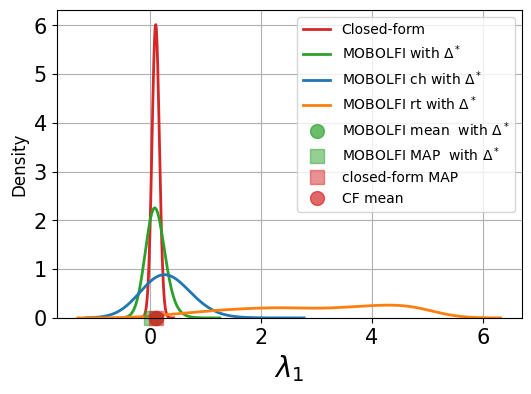

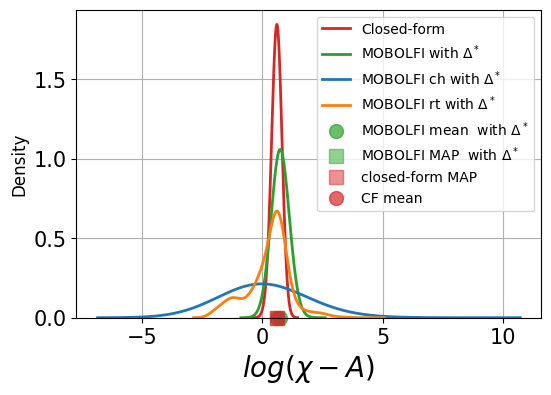

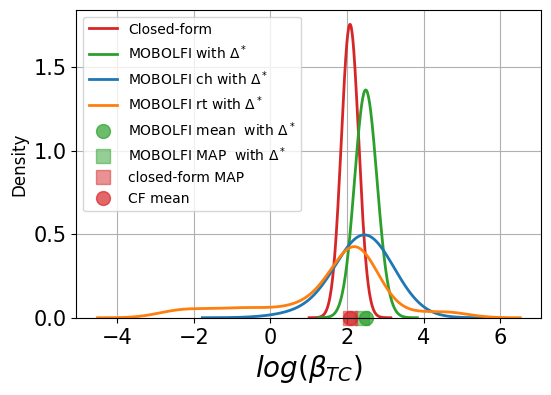

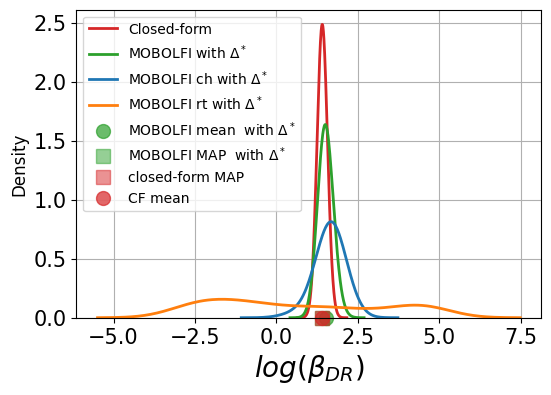

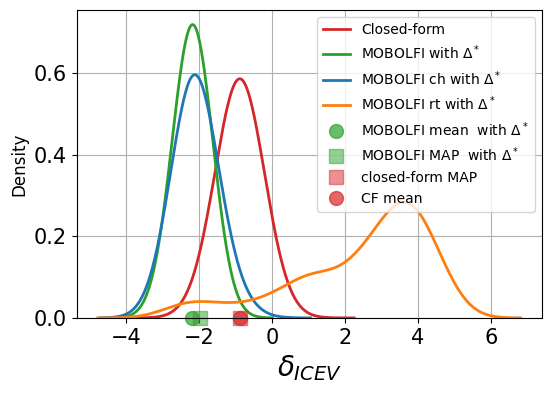

In [160]:
import seaborn as sns


font_size_text = 20
fs=10

param_list = [r'$\lambda_1$',r'$log (\chi-A)$',r'$log(\beta_{TC})$',r'$log(\beta_{DR})$',r'$\delta_{ICEV}$']

mobolfi_llk_index = [0,4,2,3,1]


# betaTC,betaDR,delta,lam1,zeta

closed_llk_index = [3,4,0,1,2]
point_coords_demcmc = coords_demcmc_last_dgn[1:,:]
point_coords_demcmc_rt = coords_demcmc_last_dgn_rt[1:,:]
point_coords_demcmc_ch = coords_demcmc_last_dgn_ch[1:,:]
point_coords_demcmc_cf = coords_demcmc_mlbaclosed_dgn





index_joint = np.argmax(point_coords_demcmc[:,-1])
index_rt = np.argmax(point_coords_demcmc_rt[:,-1])
index_ch = np.argmax(point_coords_demcmc_ch[:,-1])
index_cf = np.argmax(point_coords_demcmc_cf.iloc[:,-1])
param_name = ["lam1","log_chi","log_betaTC","log_betaDR","deltaICEV"]
for i in range(num_of_parameters):
    plt.figure(figsize=[6, 4])
   
    
    if mobolfi_llk_index[i] ==1:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
       
    elif mobolfi_llk_index[i] ==0:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=15, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
    
    else:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
        
            
    sns.kdeplot(coords_demcmc_rt_last[1:,mobolfi_llk_index[i]], label='MOBOLFI rt with $\Delta^*$',bw_adjust=2,color = "C1",linewidth=2)#,clip = (-0.5,3))
            
    plt.plot([coords_demcmc_last[:,mobolfi_llk_index[i]].mean()],[0],marker = 'o',ls = 'none',label='MOBOLFI mean  with $\Delta^*$',clip_on=False, color = "C2",alpha=.7,markersize = 10)
    plt.plot([point_coords_demcmc[index_joint,mobolfi_llk_index[i]]],[0],marker = 's',ls = 'none',label='MOBOLFI MAP  with $\Delta^*$',clip_on=False, color = "C2",alpha=.5,markersize = 10)
    plt.plot(real_theta_u[mobolfi_llk_index[i]],[0],marker = 's',ls = 'none',label='closed-form MAP',clip_on=False,color = "C3",alpha=.5,markersize = 10)
    plt.plot(coords_demcmc_mlbaclosed.mean().tolist()[closed_llk_index[i]],[0],marker = 'o',ls = 'none',label='CF mean',clip_on=False,color = "C3",alpha=.7,markersize = 10)

    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[i],fontsize=20)
    plt.ylabel("Density",fontsize=12)
    # plt.axis('off')
    legend = plt.legend(fontsize=10)
   
    # plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_post_MAP'+param_name[i]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()







# Misspecification



In [98]:
def per_iter_dis(row,test_theta):
   return minus_simluated_discrepancy(theta=([test_theta[0], real_theta[1]], real_theta[2],[test_theta[2],test_theta[3]], [test_theta[1],real_theta[4]],test_theta[-1]), X_response=real_response)[0]
  

In [ ]:
joint_mean = coords_demcmc_last[:,:-1].mean(axis=0)
joint_MAP = point_coords_demcmc[index_joint,:-1] 
joint_median = np.quantile(coords_demcmc_last[:,:-1], q = 0.1, axis=0)
  
print(joint_MAP)
print(joint_mean)
print(joint_median)

[ 1.0034867e-03 -1.9750353e+00  2.3927526e+00  1.4079852e+00
  6.0442520e-01]
[ 0.0953928  -2.19288044  2.49165287  1.51626138  0.7523098 ]
[ 0.00983879 -2.575018    2.3025184   1.3718214   0.511188  ]


In [ ]:
dis_matrix_cf = pd.DataFrame(Parallel(n_jobs= 15)(delayed(per_iter_dis)(row, real_theta_u) for row in range(1000)))
print ("half is finished")
dis_matrix_mobolfi = pd.DataFrame(Parallel(n_jobs= 15)(delayed(per_iter_dis)(row, joint_MAP) for row in range(1000)))
dis_matrix_mobolfi.to_csv("em_1e3_mobolfi_discrepancy_MAP.csv",header=False,index=False)
print ("half is finished")
dis_matrix_mobolfi_mean = pd.DataFrame(Parallel(n_jobs= 15)(delayed(per_iter_dis)(row, joint_mean) for row in range(1000)))
dis_matrix_mobolfi_mean.to_csv("em_1e3_mobolfi_discrepancy_mean.csv",header=False,index=False)



half is finished


In [186]:
print("MOBOLFI joint llk of joint MAP",approximate_log_posterior(theta=torch.Tensor(joint_MAP).view(-1)))
print("MOBOLFI joint llk of joint mean",approximate_log_posterior(theta=torch.Tensor(joint_mean).view(-1)))
print("MOBOLFI joint llk of joint median",approximate_log_posterior(theta=torch.Tensor(joint_median).view(-1)))

print("MOBOLFI joint llk of CF MAP",approximate_log_posterior(theta=torch.Tensor(real_theta_u).view(-1)))
# print("MOBOLFI joint llk of CF mean",approximate_log_posterior(theta=torch.Tensor(CF_mean_u).view(-1)))
print("MOBOLFI joint llk of best point in training",approximate_log_posterior(theta=torch.Tensor(test_theta).view(-1)))
print("Pred Discrepancy Mean of joint MAP", gp.posterior(torch.from_numpy(np.array([joint_MAP])).to(torch.float32)).mean[0])
print("Pred Discrepancy Mean of joint mean", gp.posterior(torch.from_numpy(np.array([joint_mean])).to(torch.float32)).mean[0])
print("Pred Discrepancy Mean of joint median", gp.posterior(torch.from_numpy(np.array([joint_median])).to(torch.float32)).mean[0])

print("Pred Discrepancy Mean of CF MAP", gp.posterior(torch.from_numpy(np.array([real_theta_u])).to(torch.float32)).mean[0])
# print("Pred Discrepancy Mean of CF mean", gp.posterior(torch.from_numpy(np.array([CF_mean_u]))).mean[0])
print("Pred Discrepancy Mean of best point in training", gp.posterior(test_theta.view(1,-1)).mean[0])
print("Real Discrepancy of joint MAP", per_iter_dis(1,joint_MAP))
print("Real Discrepancy of joint mean", per_iter_dis(1,joint_mean))
print("Real Discrepancy of joint median", per_iter_dis(1,joint_median))

print("Real Discrepancy of CF MAP", per_iter_dis(1,real_theta_u))
# print("Real Discrepancy of CF mean", per_iter_dis(1,CF_mean_u))
print("Real Discrepancy of best points", per_iter_dis(1,test_theta))
print("joint MAP:", joint_MAP)
print("joint mean:", joint_mean)
print("joint median:", joint_median)

print("CF MAP:", real_theta_u)
# print("CF mean:", CF_mean_u)
print("best points:", test_theta)


# joint mean: [ 0.09503041 -2.19883159  2.49442969  1.51786799  0.75162196]
# joint mean: [ 0.09491359 -2.19626898  2.49255687  1.51782697  0.75187511]

MOBOLFI joint llk of joint MAP tensor([-5.1586])
MOBOLFI joint llk of joint mean tensor([-6.5811])
MOBOLFI joint llk of joint median tensor([-9.2739])
MOBOLFI joint llk of CF MAP tensor([-23.2730])
MOBOLFI joint llk of best point in training tensor([-11.0268])
Pred Discrepancy Mean of joint MAP tensor([3.2170, 4.2087], grad_fn=<SelectBackward0>)
Pred Discrepancy Mean of joint mean tensor([2.9872, 4.2758], grad_fn=<SelectBackward0>)
Pred Discrepancy Mean of joint median tensor([2.9831, 3.8799], grad_fn=<SelectBackward0>)
Pred Discrepancy Mean of CF MAP tensor([2.6162, 3.3914], grad_fn=<SelectBackward0>)
Pred Discrepancy Mean of best point in training tensor([3.2811, 4.3064], grad_fn=<SelectBackward0>)
Real Discrepancy of joint MAP [3.29831925 3.95370593]
Real Discrepancy of joint mean [2.3563352  3.50865947]
Real Discrepancy of joint median [2.89093746 3.41966772]
Real Discrepancy of CF MAP [2.99904514 4.205673  ]
Real Discrepancy of best points [3.3449238  4.18802186]
joint MAP: [ 1.00

In [ ]:
# # results
# dis_matrix_cf= pd.read_csv("em_1e3_cf_discrepancy_MAP.csv")
# dis_matrix_mobolfi= pd.read_csv("em_1e3_mobolfi_discrepancy_MAP.csv")
# dis_matrix_mobolfi_mean= pd.read_csv("em_1e3_mobolfi_discrepancy_mean.csv")

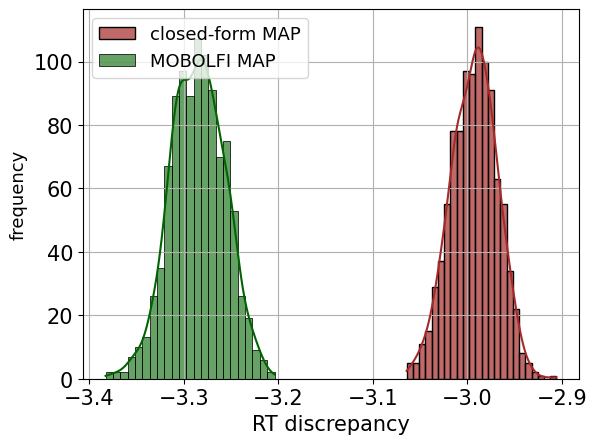

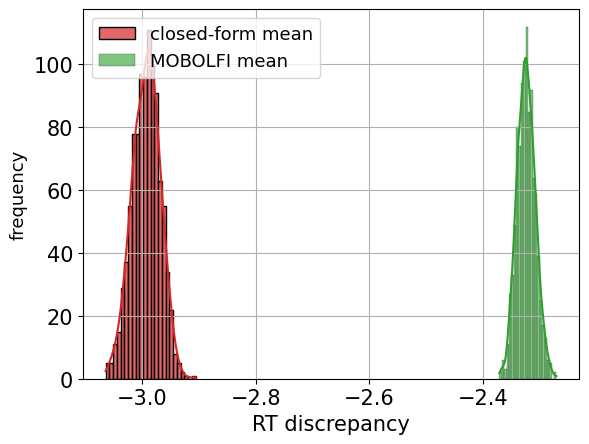

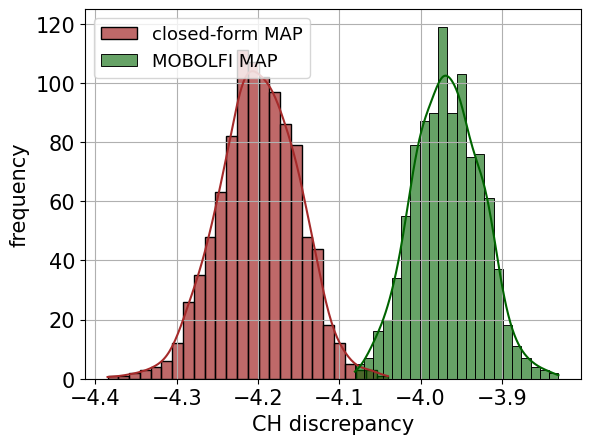

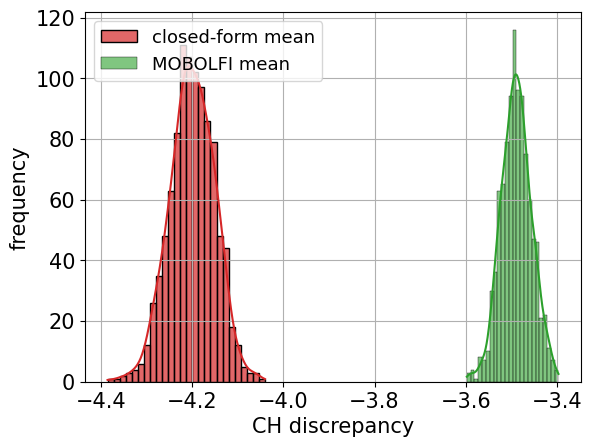

In [ ]:
import seaborn as sns
from statistics import mode

# MAP CH comparison
sns.histplot(-1*dis_matrix_cf.iloc[:,0].to_numpy() , label='closed-form MAP', color = 'brown',alpha =0.7, kde=True)
sns.histplot(-1*dis_matrix_mobolfi.iloc[:,0].to_numpy() , label='MOBOLFI MAP', color = 'darkgreen',alpha =0.6, kde=True)

plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)
plt.ylabel("frequency",fontsize=13)
plt.xlabel("RT discrepancy",fontsize=15)
# plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_post_MAP_CH.pdf',dpi = 1080,bbox_inches='tight') 
plt.show()

# mean CH comparison
sns.histplot(-1*dis_matrix_cf.iloc[:,0].to_numpy() , label='closed-form mean', color = 'C3',alpha =0.7, kde=True)
sns.histplot(-1*dis_matrix_mobolfi_mean.iloc[:,0].to_numpy() , label='MOBOLFI mean', color = "C2",alpha =0.6, kde=True)
plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)
plt.ylabel("frequency",fontsize=13)
plt.xlabel("RT discrepancy",fontsize=15)
# plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_post_mean_CH.pdf',dpi = 1080,bbox_inches='tight') 
plt.show()


# MAP RT comparison
sns.histplot(-1*dis_matrix_cf.iloc[:,1].to_numpy() , label='closed-form MAP', color = 'brown',alpha =0.7, kde=True)
sns.histplot(-1*dis_matrix_mobolfi.iloc[:,1].to_numpy() , label='MOBOLFI MAP', color = 'darkgreen',alpha =0.6, kde=True)

plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)
plt.ylabel("frequency",fontsize=15)
plt.xlabel("CH discrepancy",fontsize=15)
# plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_post_MAP_RT.pdf',dpi = 1080,bbox_inches='tight') 
plt.show()

# mean RT comparison
sns.histplot(-1*dis_matrix_cf.iloc[:,1].to_numpy() , label='closed-form mean', color = 'C3',alpha =0.7, kde=True)
sns.histplot(-1*dis_matrix_mobolfi_mean.iloc[:,1].to_numpy() , label='MOBOLFI mean', color = "C2",alpha =0.6, kde=True)

plt.legend(fontsize=13,loc='upper left')
plt.grid()
plt.tick_params(axis='both', labelsize=15)
plt.ylabel("frequency",fontsize=15)
plt.xlabel("CH discrepancy",fontsize=15)
# plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_em_post_mean_RT.pdf',dpi = 1080,bbox_inches='tight') 
plt.show()

# Diagmosis plots

In [134]:
# all 
chain_num = 9
coords_demcmc_all_chains = np.zeros((chain_num+2, int(iter_num_last), num_of_parameters+1))
index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last))):
    sample_onechain = coords_demcmc_dgn_last[j,] 
    coords_demcmc_all_chains[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0
        
# stationary samples     
coords_demcmc_all_chains_sta = np.zeros((chain_num+2, 1000, num_of_parameters+1))
index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last_sta))):
    sample_onechain = coords_demcmc_dgn_last_sta[j,] 
    coords_demcmc_all_chains_sta[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0


In [135]:
# all
chain_num = 9
coords_demcmc_all_chains_ch = np.zeros((chain_num+2, int(iter_num_last_ch), num_of_parameters+1))
index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last_ch))):
    sample_onechain = coords_demcmc_dgn_last_ch[j,] 
    coords_demcmc_all_chains_ch[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0
        
# stationary sample        
coords_demcmc_all_chains_sta_ch = np.zeros((chain_num+2, 1000, num_of_parameters+1))
index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last_sta_ch))):
    sample_onechain = coords_demcmc_dgn_last_sta_ch[j,] 
    coords_demcmc_all_chains_sta_ch[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0

In [136]:
chain_num = 9

coords_demcmc_all_chains_rt = np.zeros((chain_num+2, int(iter_num_last_rt), num_of_parameters+1))

index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last_rt))):
    sample_onechain = coords_demcmc_dgn_last_rt[j,] 
    coords_demcmc_all_chains_rt[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0
        
# stationary sample        
coords_demcmc_all_chains_sta_rt = np.zeros((chain_num+2, 1000, num_of_parameters+1))
index_chain = 0
for j in range(1,int(len(coords_demcmc_dgn_last_sta_rt))):
    sample_onechain = coords_demcmc_dgn_last_sta_rt[j,] 
    coords_demcmc_all_chains_sta_rt[index_chain,(j-1)//(chain_num+2),:] = sample_onechain
    index_chain+=1
    if index_chain == chain_num+2:
        index_chain = 0

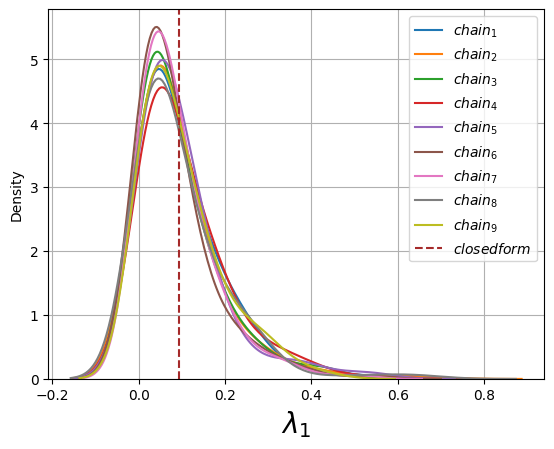

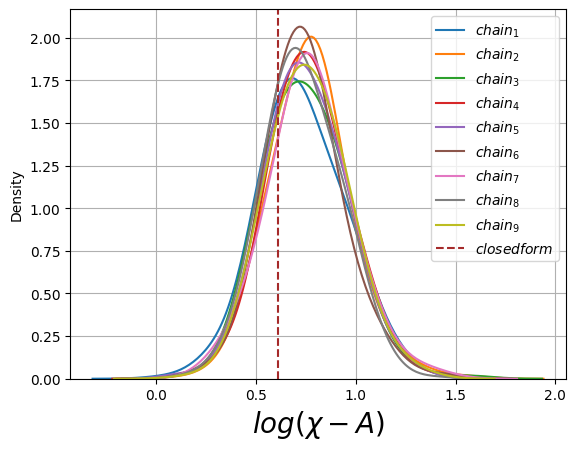

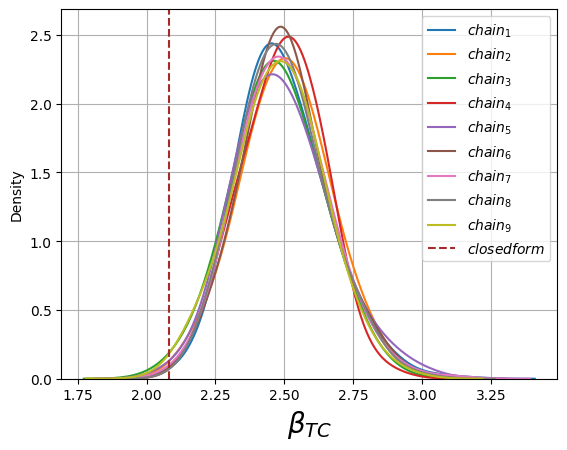

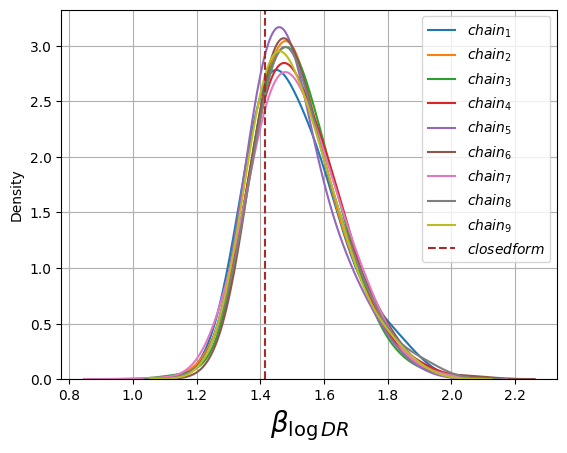

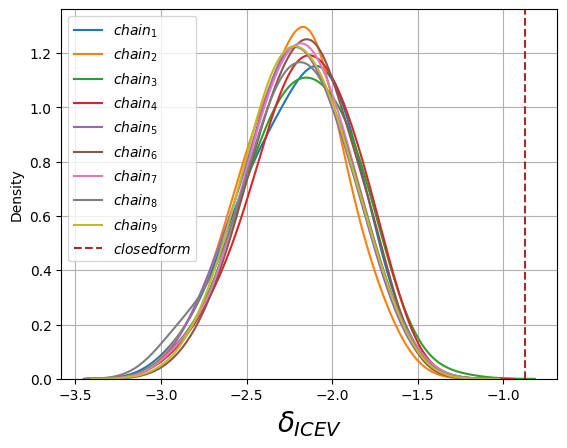

In [137]:
#Multiple chains diagnostics
import seaborn as sns

chain_list = ['$chain_1$','$chain_2$','$chain_3$','$chain_4$','$chain_5$','$chain_6$','$chain_7$','$chain_8$','$chain_9$']
param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']
mobolfi_llk_index = [0,4,2,3,1]



for i in range(num_of_parameters):
    for j in range(chain_num):
        # sns.kdeplot(coords_demcmc_all_chains[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
        sns.kdeplot(coords_demcmc_all_chains_sta[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
    plt.axvline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$closed form$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()



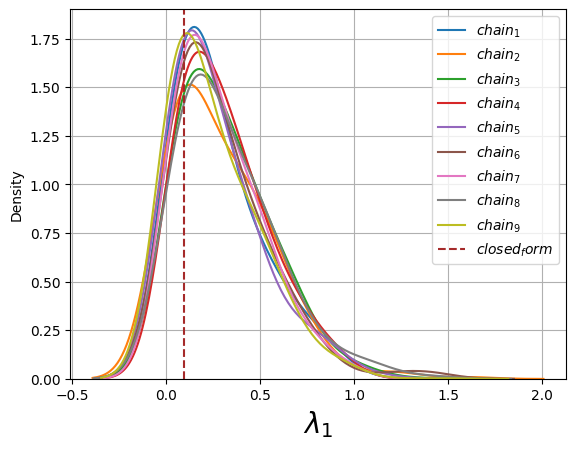

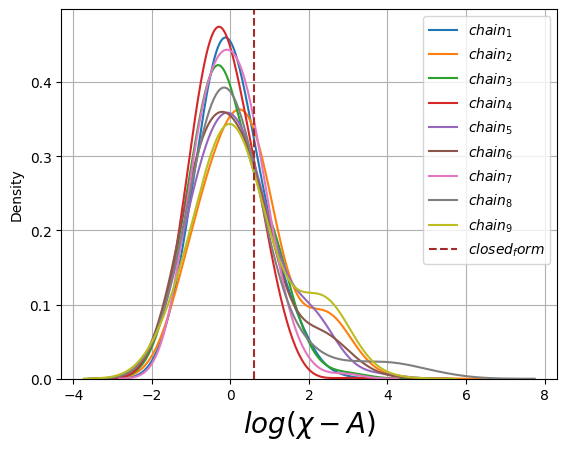

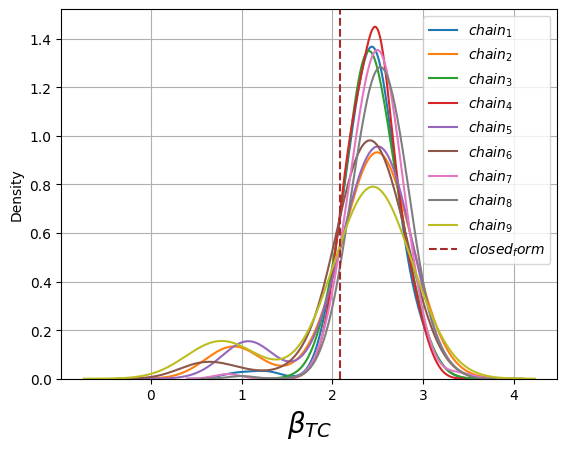

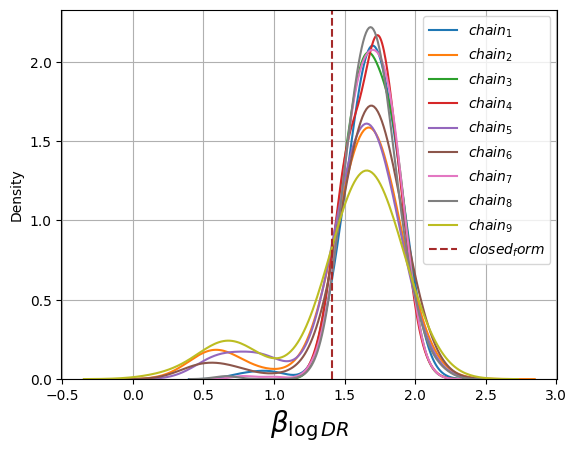

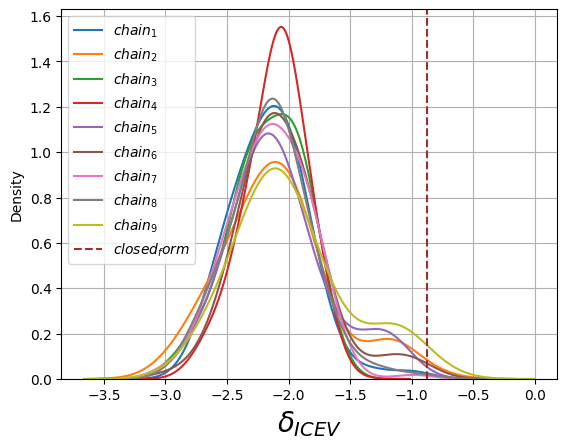

In [147]:
#Multiple chains diagnostics
import seaborn as sns


chain_list = ['$chain_1$','$chain_2$','$chain_3$','$chain_4$','$chain_5$','$chain_6$','$chain_7$','$chain_8$','$chain_9$']

# mobolfi_llk_index = [0,4,2,3,1]


for i in range(num_of_parameters):
    for j in range(chain_num):
        # sns.kdeplot(coords_demcmc_all_chains_ch[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
        sns.kdeplot(coords_demcmc_all_chains_sta_ch[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
    plt.axvline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$closed_form$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

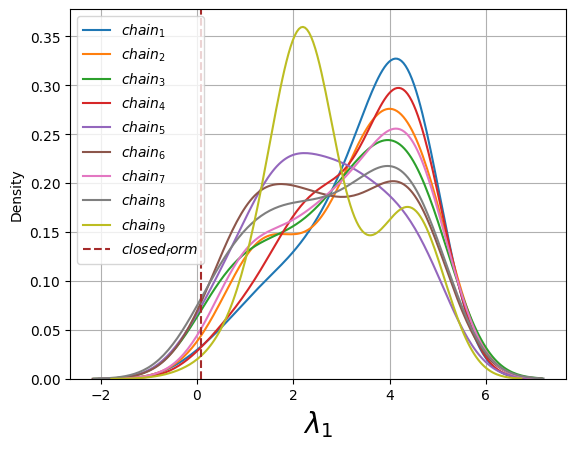

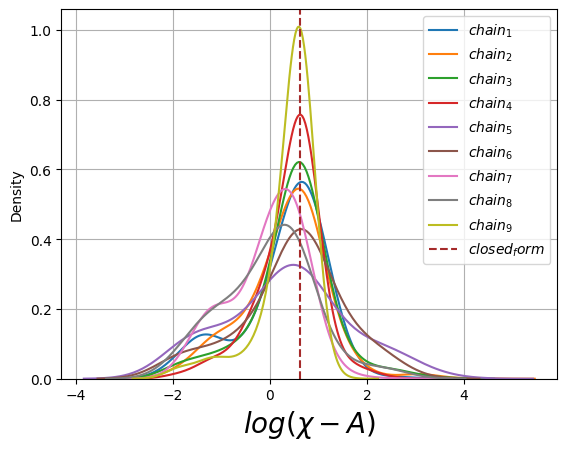

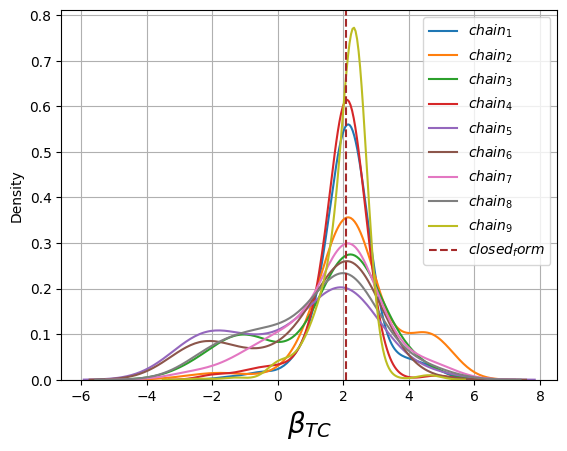

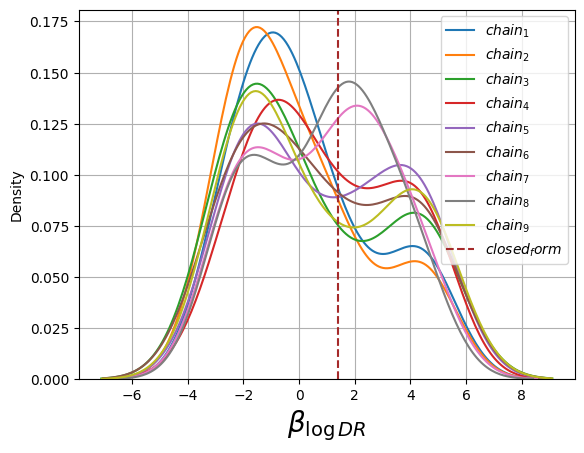

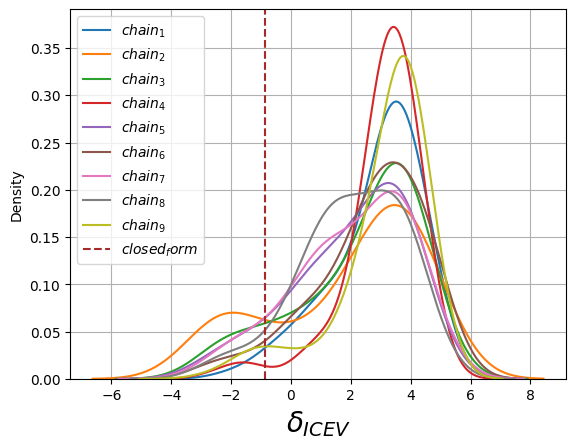

In [148]:
#Multiple chains diagnostics
import seaborn as sns


chain_list = ['$chain_1$','$chain_2$','$chain_3$','$chain_4$','$chain_5$','$chain_6$','$chain_7$','$chain_8$','$chain_9$']
chain_num = 9
# mobolfi_llk_index = [0,4,2,3,1]


for i in range(num_of_parameters):
    for j in range(chain_num):
        # sns.kdeplot(coords_demcmc_all_chains_rt[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
        sns.kdeplot(coords_demcmc_all_chains_sta_rt[j][:-1,mobolfi_llk_index[i]], label=chain_list[j],bw_adjust=2)
    plt.axvline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$closed_form$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


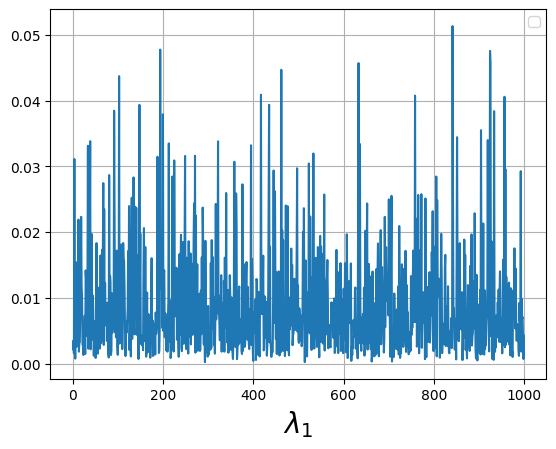

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


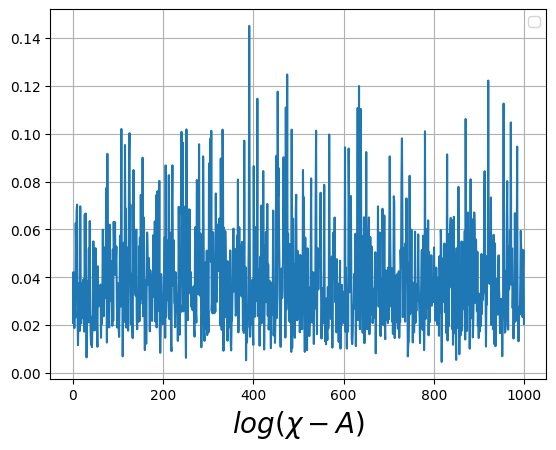

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


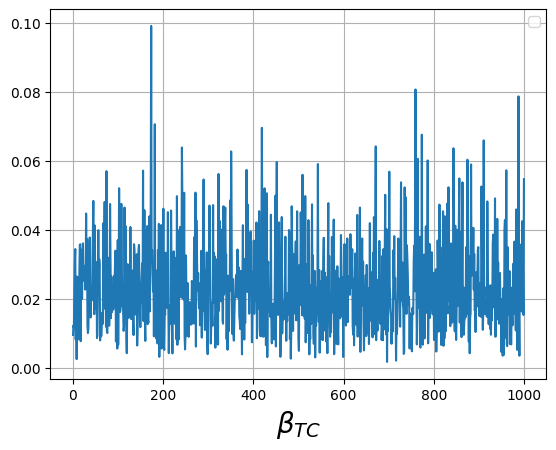

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


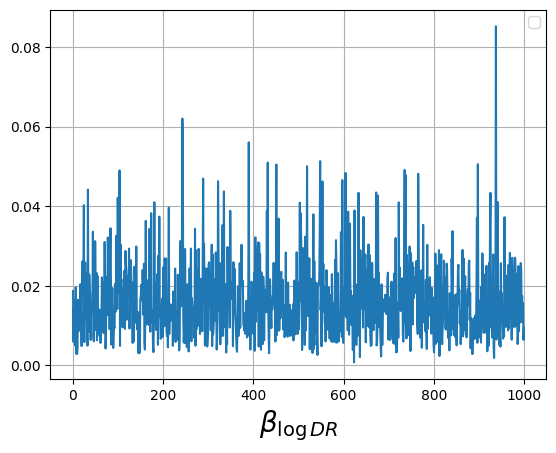

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


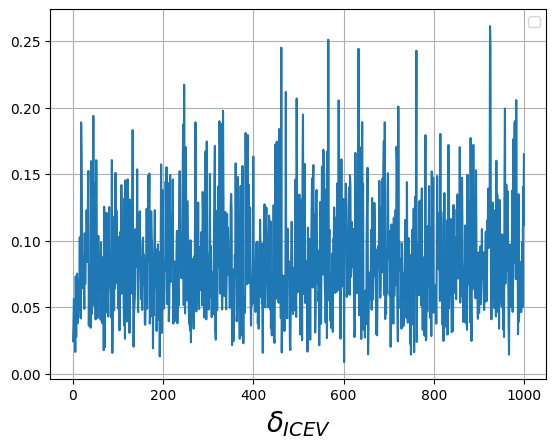

In [149]:
# Trace plots
# param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']
# mobolfi_llk_index = [0,4,3,2,1]
for i in range(num_of_parameters):

    # check chain sd in stationary period
    plt.plot(list(range(1,coords_demcmc_all_chains_sta[-1].shape[0])),coords_demcmc_all_chains_sta[-1][1:,mobolfi_llk_index[i]])
    
    # plt.plot(list(range(46000,coords_demcmc_all_chains[-1].shape[0])),coords_demcmc_all_chains[-1][46000:,mobolfi_llk_index[i]])
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


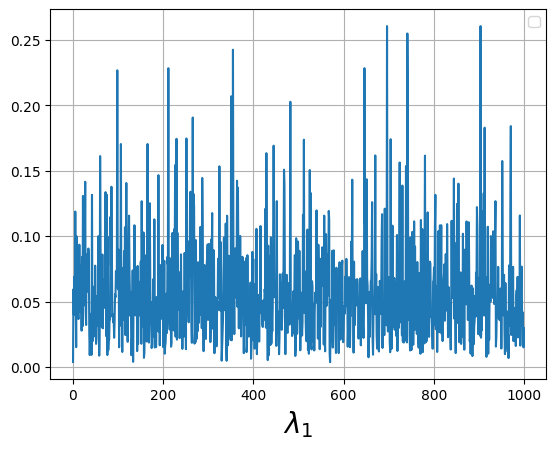

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


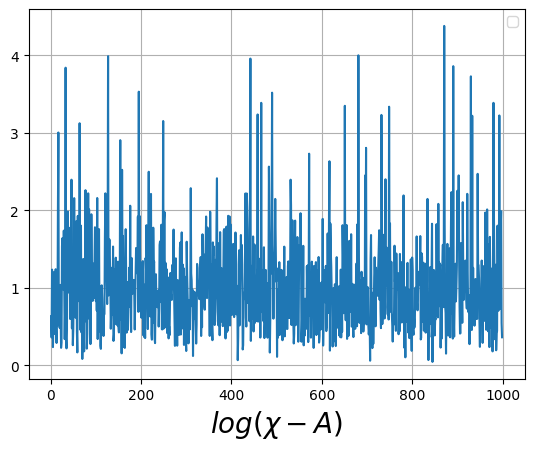

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


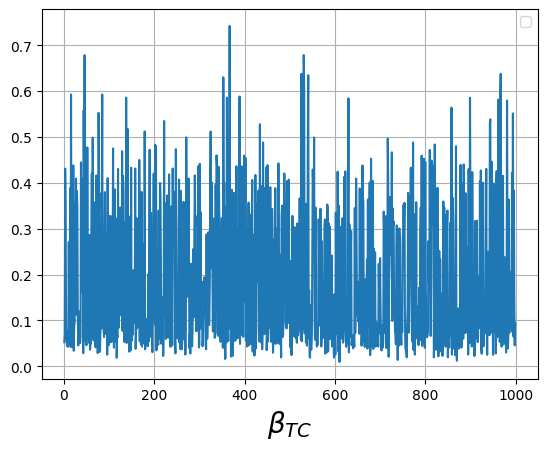

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


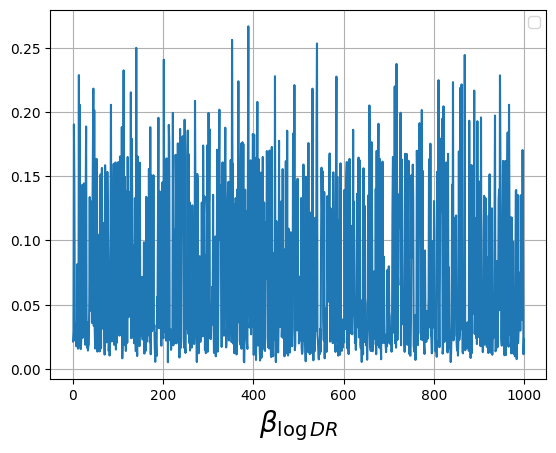

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


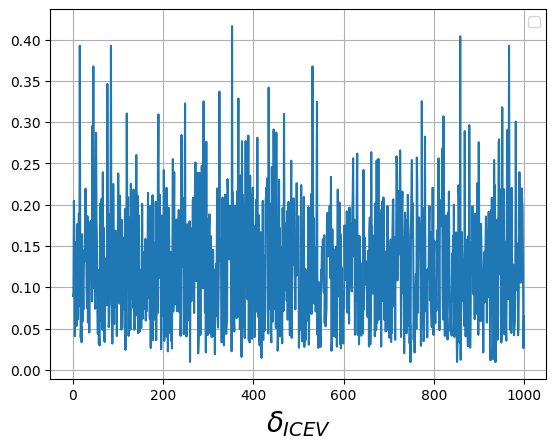

In [150]:
# Trace plots
# param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']
# mobolfi_llk_index = [0,4,3,2,1]
for i in range(num_of_parameters):

    # check chain sd in stationary period
    plt.plot(list(range(1,coords_demcmc_all_chains_sta_ch[-1].shape[0])),coords_demcmc_all_chains_sta_ch[-1][1:,mobolfi_llk_index[i]])
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


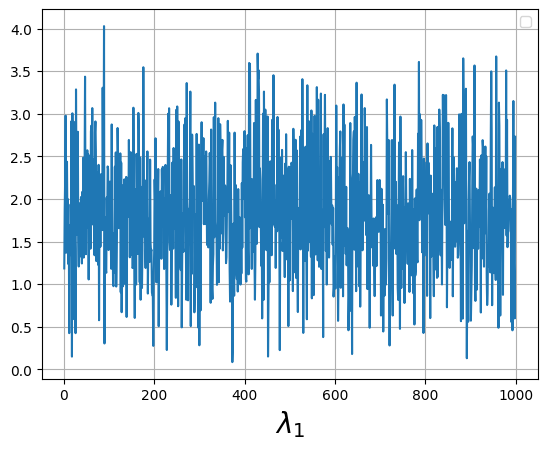

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


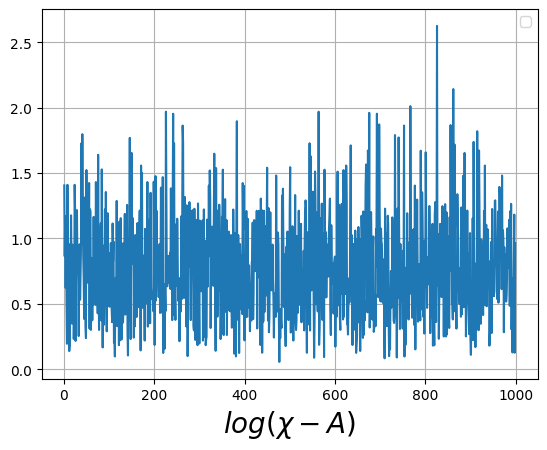

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


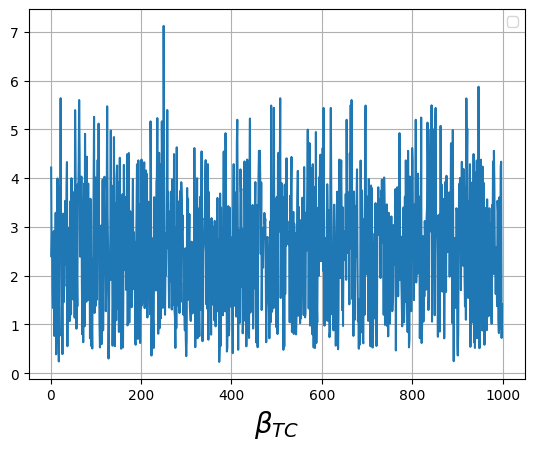

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


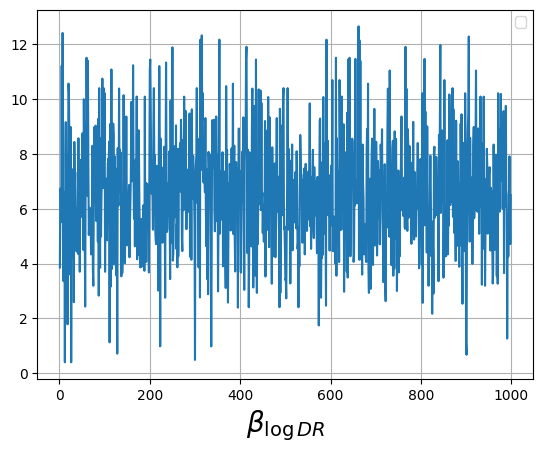

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


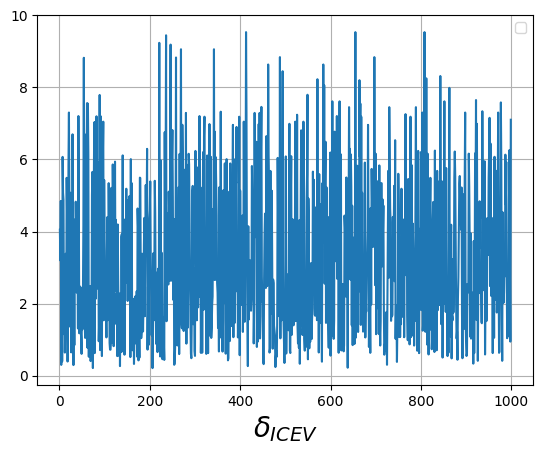

In [151]:
# Trace plots
# param_list = ['$\lambda_1$','$log (\chi-A)$',r'$\beta_{TC}$',r'$\beta_{\log DR}$','$\delta_{ICEV}$']
# mobolfi_llk_index = [0,4,3,2,1]
for i in range(num_of_parameters):

    # check chain sd in stationary period
    # plt.plot(list(range(30000,coords_demcmc_all_chains_rt[-1].shape[0])),coords_demcmc_all_chains_rt[-1][30000:,mobolfi_llk_index[i]])
    plt.plot(list(range(1,coords_demcmc_all_chains_sta_rt[-1].shape[0])),coords_demcmc_all_chains_sta_rt[-1][1:,mobolfi_llk_index[i]])
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

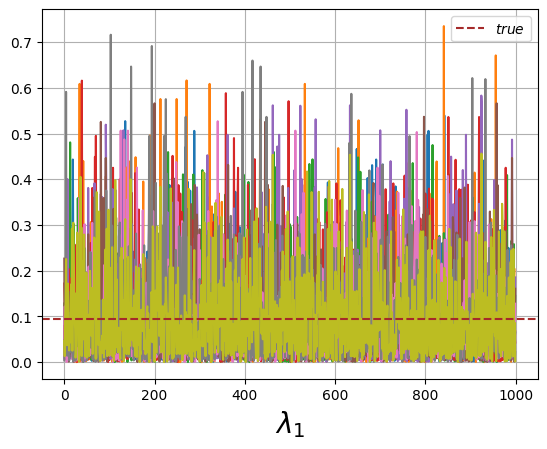

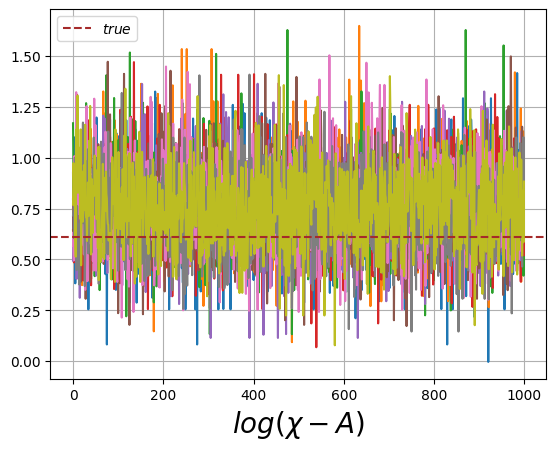

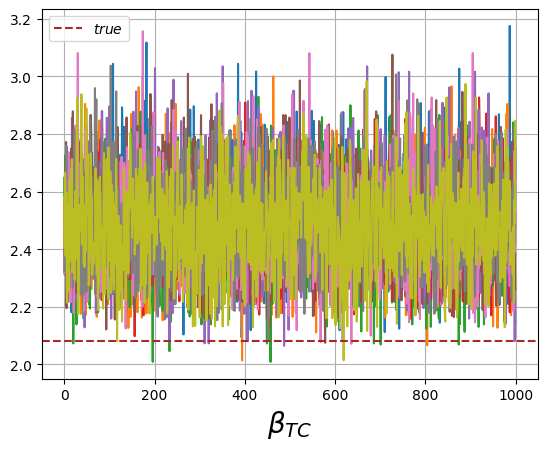

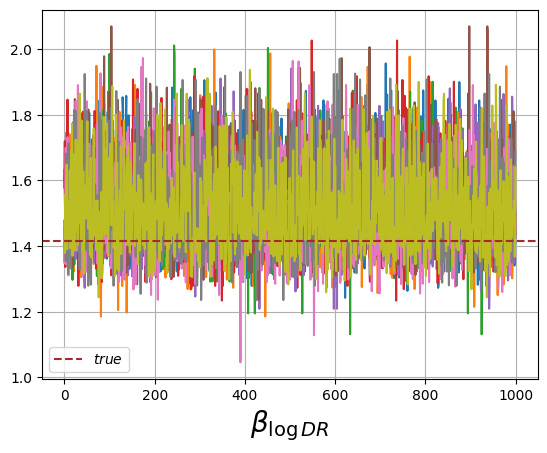

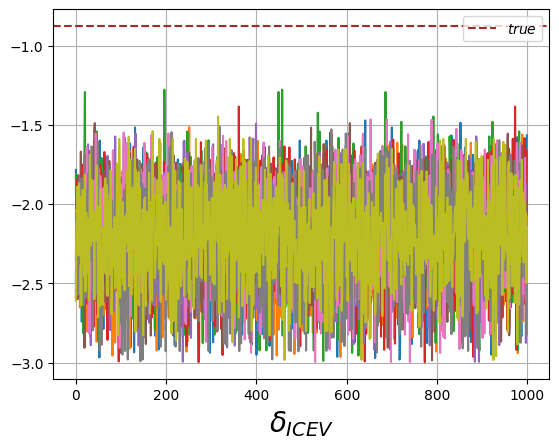

In [152]:
# Trace plots
chain_num = 9
for i in range(num_of_parameters):
    for j in range(chain_num):
        # plt.plot(list(range(1,coords_demcmc_all_chains[j].shape[0])),coords_demcmc_all_chains[j][:-1,mobolfi_llk_index[i]])
        plt.plot(list(range(0,coords_demcmc_all_chains_sta[j].shape[0])),coords_demcmc_all_chains_sta[j][:,mobolfi_llk_index[i]])
    plt.axhline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$true$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

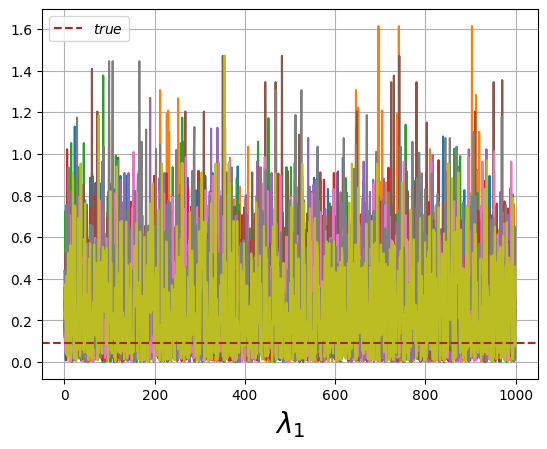

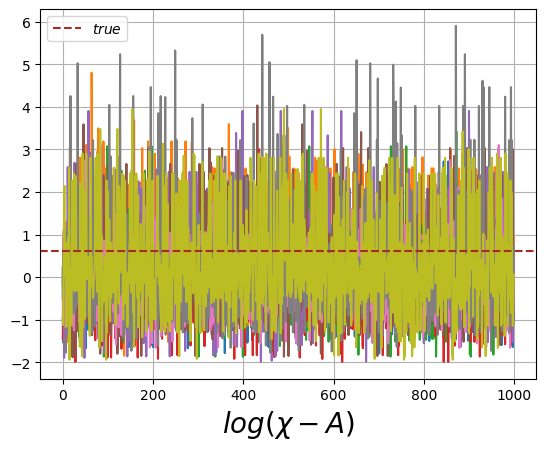

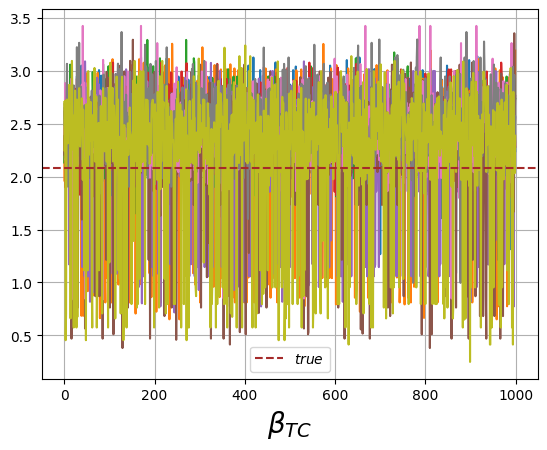

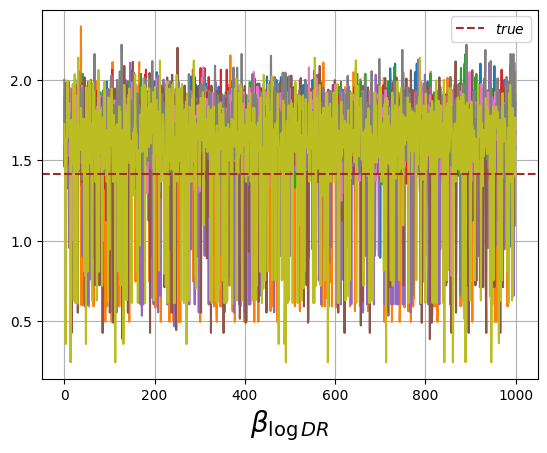

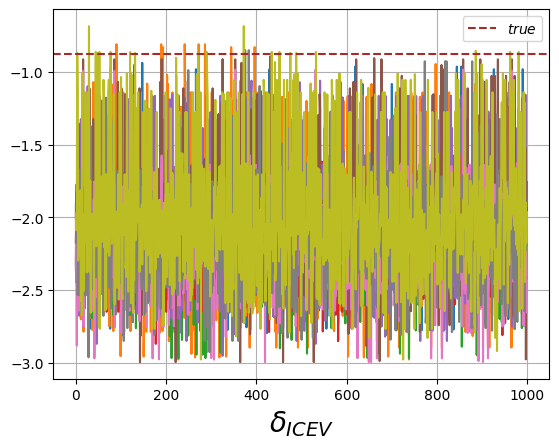

In [153]:
# Trace plots
for i in range(num_of_parameters):
    for j in range(chain_num):
        plt.plot(list(range(0,coords_demcmc_all_chains_sta_ch[j].shape[0])),coords_demcmc_all_chains_sta_ch[j][:,mobolfi_llk_index[i]])
        
    plt.axhline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$true$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

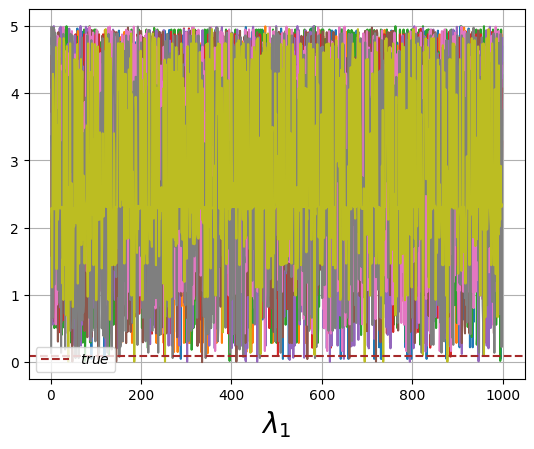

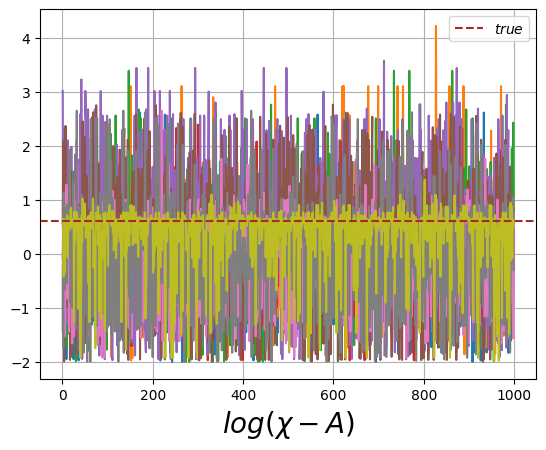

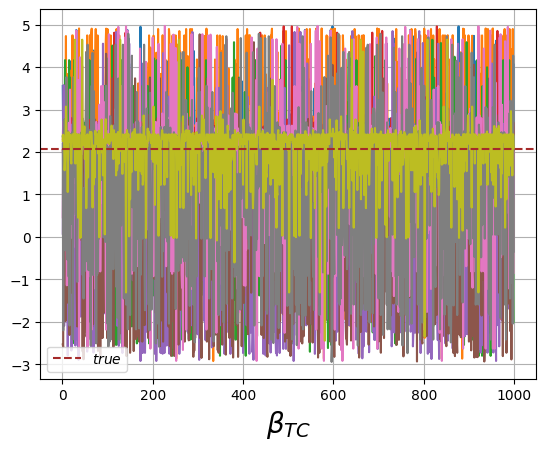

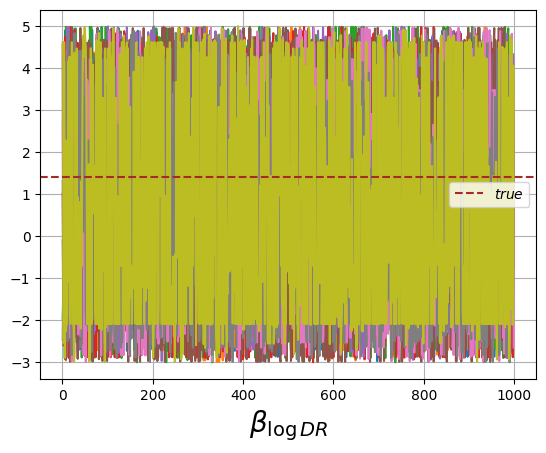

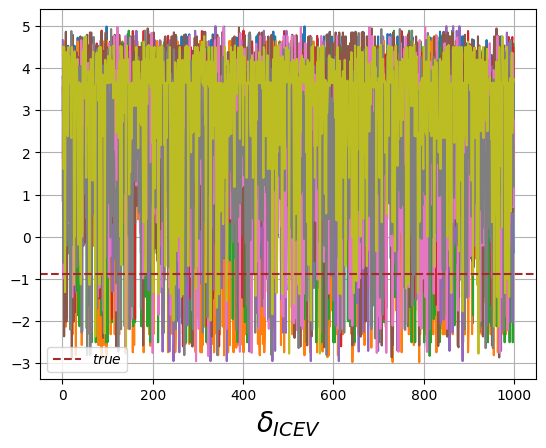

In [154]:
# Trace plots
chain_num = 9
for i in range(num_of_parameters):
    for j in range(chain_num):
        plt.plot(list(range(1,coords_demcmc_all_chains_sta_rt[j].shape[0])),coords_demcmc_all_chains_sta_rt[j][:-1,mobolfi_llk_index[i]])
    plt.axhline(real_theta_u[mobolfi_llk_index[i]],0,1,linestyle="--",c='brown',label='$true$')
    plt.legend(fontsize=fs)
    plt.grid()
    plt.tick_params(axis='both', labelsize=fs)
    plt.xlabel(param_list[i],fontsize=font_size_text)
    plt.show()

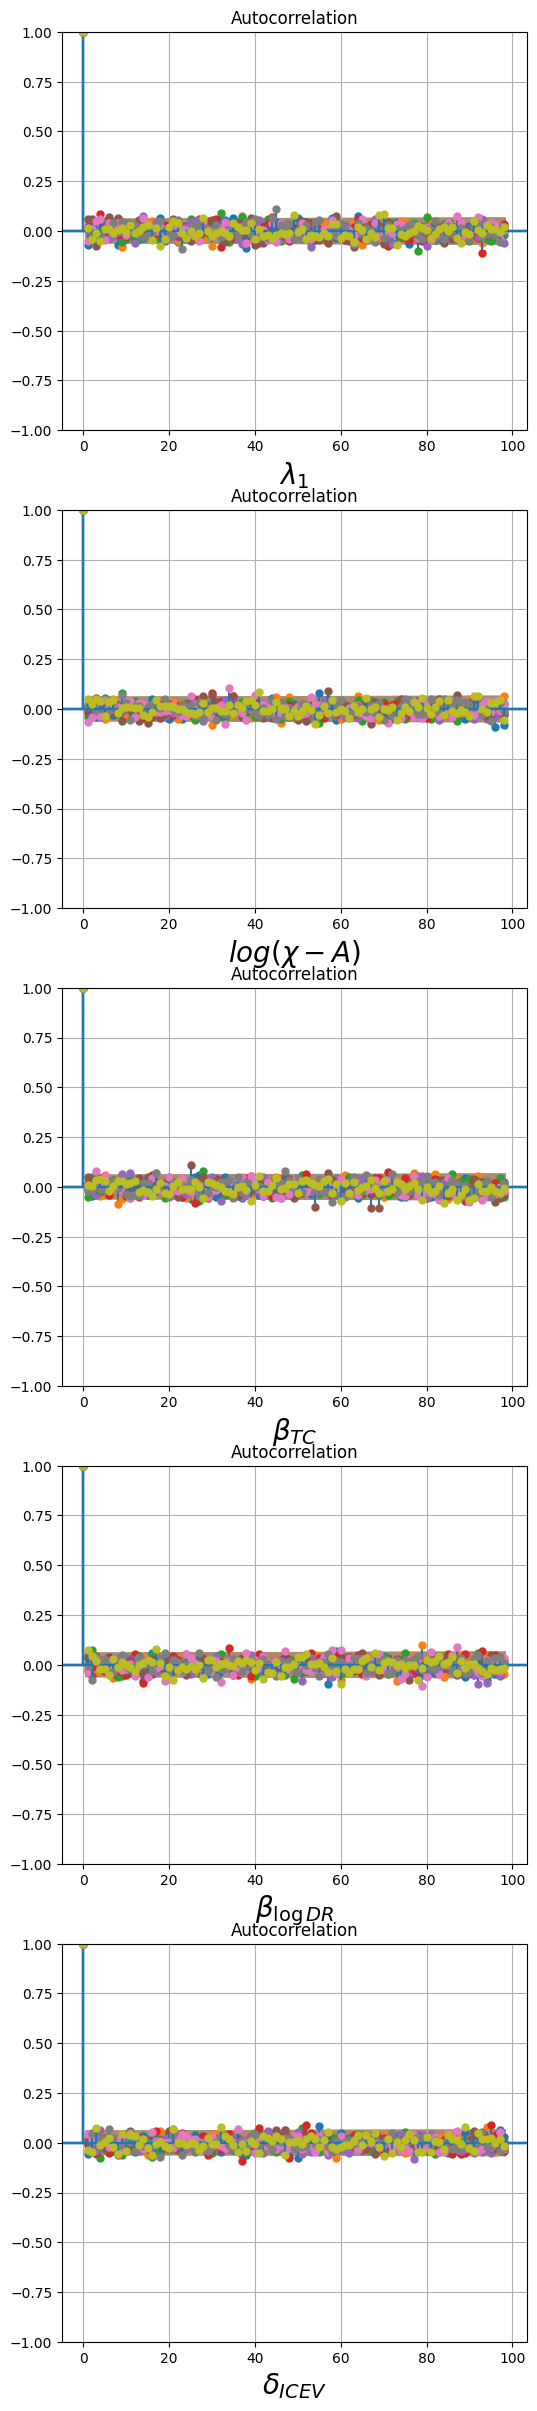

In [155]:
# ACF plots
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(num_of_parameters, 1, figsize=(6,num_of_parameters*6),sharey=True)
chain_num = 9
for i in range(num_of_parameters):
    for j in range(chain_num):
        plot_acf(coords_demcmc_all_chains_sta[j][:-1,mobolfi_llk_index[i]], ax=axs[i],lags=98)
    axs[i].grid()
    axs[i].tick_params(axis='both', labelsize=fs)
    axs[i].set_xlabel(param_list[i],fontsize=font_size_text)

plt.show()

In [35]:
real_theta

[0.09404336, 0, 0, -0.8758533, 0, 2.080699, 1.414022, 0.6108216]

In [41]:
real_theta_u = [real_theta[0],real_theta[3],real_theta[5],real_theta[6],real_theta[7]]
real_theta_u

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [41]:
import pickle

# loaded_model
gp= pickle.load(open('mobolfi_gp_modelem_1001iter_1quantiletol_5_1115_logdis_v3.sav', 'rb'))

print(gp.posterior(torch.Tensor(real_theta_u).view(1,-1)).mean)

tensor([[2.7134, 3.6561]], dtype=torch.float64, grad_fn=<TransposeBackward0>)


In [47]:
# np.savetxt('mobolfi_em_2048iter_cov_est_noise_5_1115_logdis_v4.txt', cov_est_noise, fmt='%.15f')
cov_est_noise = np.loadtxt('mobolfi_em_2048iter_cov_est_noise_5_1115_logdis_v4.txt', dtype=np.dtype('float64'))
# # np.where(np.abs(cov_est_noise - cov_est_noiseb)>=1e-8)

In [48]:
# np.savetxt('mobolfi_em_2048iter_1quantiletol_5_1115_logdis_v4.txt', tol, fmt='%.15f')
tol = np.loadtxt('mobolfi_em_2048iter_1quantiletol_5_1115_logdis_v4.txt', dtype=np.dtype('float64'))

# np.where(np.abs(tol - tolb)>=1e-8)

In [437]:
import pandas as pd
#First 100 abs are init data
df_X = pd.DataFrame(train_X.detach().numpy())
df_X.to_csv("em_1270iter_1quantiletol_5_train_X_1115_logdis_250_v3.csv",header=False,index=False)

In [438]:
df_Y = pd.DataFrame(train_Y.detach().numpy())
df_Y.to_csv("em_1270iter_1quantiletol_5_train_Y_1115_logdis_250_v3.csv",header=False,index=False)